This notebook aims to conduct feature engineering for our PD Model. Order of feature engineering is as followed: 

1) Creation of Features 
2) Feature Selection via IV  <-> WoE binning selected features

This sequence is chosen due to the following reasons: 
- Reduce chance of discarding features, which may only become useful after feature engineering
- Generating interaction features allow me to rank / select variables which are relevant and useful for PD Modeling
- Multicollinearity checks can be conducted once, instead of being repeated multiple times 


# 0. Import Libraries 

In [1]:
# === Standard libraries ===
import os


# === WandB Logging  ===
import wandb
wandb.login(key=os.getenv("WANDB_API_KEY"))


# === Spark Session & Functions ===
from init_spark import start_spark
spark = start_spark()
from pyspark.sql.functions import (
    col, when, count, desc, isnan, isnull, lit, length, trim, lower, upper, to_date, concat_ws,  regexp_extract, mean 
)
from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, IntegerType, DateType, NumericType, FloatType, LongType
)


# === Pandas Dataframe & WoE Binning === 
import pandas as pd
from tabulate import tabulate
from optbinning import OptimalBinning
import numpy as np 

# == Visualisation 
import matplotlib.pyplot as plt
import seaborn as sns 

# === Machine Learning === 
from sklearn.linear_model import LogisticRegression as SkLogisticRegression
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, classification_report, 
    confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
)

# === Load Environment Variables ===
from dotenv import load_dotenv
load_dotenv()

# == Global Functions ==
from functions import * 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
wandb: Currently logged in as: wlunlun1212 (wlunlun1212-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/10 00:15:06 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.77 instead (on interface en0)
25/08/10 00:15:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Defau

4.0.0


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc


In [2]:
# ============ Constants ======================

TARGET_COL = "default_status"
SAMPLE_FRAC = 0.1
SEED = 42

IV_THRESHOLDS = {
    "useless (< 0.02)": 0.02,
    "weak (< 0.1)": 0.1,
    "medium (< 0.3)": 0.3,
    "strong (< 0.5)": 0.5,
}

# === Feature Categorisation === 
iv_categories = {
    "useless (< 0.02)": [],
    "weak (< 0.1)": [],
    "medium (< 0.3)": [],
    "strong (< 0.5)": [],
    "suspicious": [],
    "no_variation": [],
}

In [3]:
# ============ Reusable Functions ======================

# == 1. Feature Engineering == 

def add_ratio_with_flag(df, numerator, denominator, ratio_col, flag_col, fill_value=-1.0):
    """
    Adds flag column to indicate invalid value upon division. Adds engineered feature column, and fills -1 upon invalid 
    division operation. 
    
    Parameters 
    ----------
    df: str 
        Spark Dataframe
        
    numerator: str 
        Numerator Column Name
    denominator: str 
        Denominator Column Name
    
    ratio_col: str 
        Engineered Feature Name (Create Yourself)
        
    flag_col: str 
        For e.g. annual_inc/loan_ratio_invalid
        
    fill_value: int 
        Default: -1 (Placeholder in flag column, if invalid division operation)
        
    Returns 
    ------- 
    Spark Dataframe with new columns (flag and divided column)
    """
    # ==  invalid denom (null or <= 0) -> 0 or -1 will be in flag columnis == 
    df = df.withColumn(
    flag_col,
    when((col(denominator).isNull()) | (col(denominator) <= 0), 1)  # invalid → 1
    .otherwise(0)                                                  # valid → 0
)
    
    # == safe ratio: real divide only when valid, else sentinel == 
    df = df.withColumn(ratio_col, when(col(flag_col) == 0, col(numerator) / col(denominator)).otherwise(lit(fill_value)))
    return df



# == 2. Feature Selection (WoE & IV) == 

def get_numerical_cols(df, target_col):
    """Gets all numerical columns, excluding target column"""
    return [
        f.name for f in df.schema.fields
        if isinstance(f.dataType, NumericType)
        and f.name != target_col
    ]

def get_categorical_cols(df, target_col):
    return [
        f.name for f in df.schema.fields
        if isinstance(f.dataType, StringType)
        and f.name != target_col
    ]
        
def classify_iv(feature, iv_score):
    """Adds 1 feature into respective IV categories of iv_categories dictionary"""
    for label, threshold in IV_THRESHOLDS.items():
        if iv_score < threshold:
            iv_categories[label].append((feature, iv_score))
            return
        
    iv_categories["suspicious"].append((feature, iv_score))
    
def first_bin_and_classify_feature(feature, x, y, dtype="numerical", 
                             
                             monotonic_trend_type='auto'):
    """
        Sample first before usage. Ensure only train_df is fed into optbinning
        
        Conducts Optimal Binning on a feature (for the 1st time) -> Outputs WoE table & Plot (to observe monotonic trend)
        Categorises 1 feature into `iv_categories` dictionary
        Inputs: 
        - feature: name of feature (String)
        - x: features (Series) 
        - y: default_status (Series)
        - dtype: numerical (continuous & discrete & ordinal variables) / nominal (strings) 
        - monotonic_trend_type= can set to auto_asc_dsc or auto
    """
    
    # Fit binning with automatic solver 
    optb = OptimalBinning(
        name=feature,
        dtype=dtype,
        monotonic_trend=monotonic_trend_type,
        min_bin_size=0.01 , # min bin size is 1% (majority of our features have >= 1% outliers ... )
        solver="cp"
    )
    optb.fit(x, y)
    bin_table = optb.binning_table.build()
    
    #  Format binning table to display bins WoE & IV
    bin_df = pd.DataFrame({
        "Bin": bin_table["Bin"].astype(str),
        "Count": round(bin_table["Count"], 4),
        "Default Rate (%)": round(bin_table["Event rate"], 4),
        "WOE": bin_table["WoE"],
        "IV": bin_table["IV"]
    })
    
    # Get total IV for feature 
    bin_df = bin_df[~bin_df["Bin"].str.contains("Total", na=False)]
    total_iv = bin_df.iloc[-1]["IV"]
    print(f"✅ Total IV for {feature}: {total_iv:.4f}")

    
    # Add feature to iv_categories
    classify_iv(feature, total_iv)
    
    
    # Print binning table 
    print(tabulate(bin_df, headers="keys", tablefmt="fancy_grid", showindex=False))
    
    # Plot curve 
    optb.binning_table.plot(metric="woe", figsize=(7,4)) 
    
def tx_grade(df): 
    # == Grade = Ordinal -> Dtype = `numerical` ==
    grade_map = {
        "A": 1,
        "B": 2,
        "C": 3,
        "D": 4,
        "E": 5,
        "F": 6,
        "G": 7
    }
    df["grade_numeric"] = df["grade"].map(grade_map)
    
    return df

def woe_bin_transform(df, non_mono_cols, target_col=TARGET_COL, monotonic='auto'): 
    """
    Transforms variables to WoE using OptimalBinning fitted on input df (train).
    Optionally returns dictionary of fitted binners for reuse on test data.
    """
    
    excluded_columns = ['id', 'issue_d', 'default_status', 'earliest_cr_line']
    loop_cols = [feature for feature in df.columns if feature not in excluded_columns]
    
    optb_dict = {}

    for column in loop_cols: 
        # == Check if we should enforce monotonic trend on current feature == 
        if column in non_mono_cols: 
            monotonic_trend = 'auto_asc_desc'
        else:
            monotonic_trend = monotonic

        # == Determine dtype of current column == 
        if df[column].dtype == 'object': 
            dtype = 'categorical'
        elif pd.api.types.is_numeric_dtype(df[column]):
            dtype = 'numerical'
        else:
            continue  # skip unknown types

        optb = OptimalBinning(name=column, dtype=dtype, monotonic_trend=monotonic_trend, solver='cp')

        try:
            optb.fit(df[column], df[target_col])
            df[column + "_woe"] = optb.transform(df[column].to_numpy(), metric="woe")
            df = df.drop(column, axis=1)
            optb_dict[column] = optb  
            
        except Exception as e:
            print(f"❌ Error fitting {column}: {e}")

    return (df, optb_dict) 

def apply_woe_transform(df, optb_dict):
    """Meant to apply woe transform to a test_df using predefined trained optbinners"""
    for column, optb in optb_dict.items():
        df[column + "_woe"] = optb.transform(df[column].to_numpy(), metric="woe")
        df = df.drop(columns=[column])
    return df



In [4]:
# == Remove all existing runs every time I run this notebook == 
NOTEBOOK_RUN_NAME = 'PD Model Building II'
api = wandb.Api()
for run in api.runs(f"wlunlun1212-singapore-management-university/Credit Risk Modeling"):                      
    if run.group == NOTEBOOK_RUN_NAME:
        run.delete()

In [5]:
df = spark.read.format("delta")\
    .load("../data/gold/feature_selection_next")
    
df.limit(10).toPandas()

25/08/10 00:15:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


id  loan_amnt  funded_amnt  term  int_rate  installment grade  \
0  60195968     7000.0       7000.0    36     16.55       248.01     D   
1  60932334    10000.0      10000.0    60     19.19       260.46     E   
2  59471356    21000.0      21000.0    36     12.69       704.45     C   
3  60635249     7400.0       7400.0    36     19.19       271.97     E   
4  60576433     3550.0       3550.0    36     15.61       124.13     D   
5  60911456    13000.0      13000.0    36      7.26       402.95     A   
6  60960964    20000.0      20000.0    36     11.53       659.81     B   
7  60286800     5000.0       5000.0    36      9.99       161.32     B   
8  60305390    15000.0      15000.0    36     11.53       494.86     B   
9  60316352     9600.0       9600.0    36     12.69       322.04     C   

   emp_length home_ownership  annual_inc  ... pct_tl_nvr_dlq percent_bc_gt_75  \
0           0            OWN     16300.0  ...          100.0              0.0   
1           7       MORTGAGE    100000.0  ...           72.4              0.0   
2           6            OWN    200000.0  ...          100.0            100.0   
3           6       MORTGAGE     21804.0  ...           93.3              0.0   
4           4       MORTGAGE     42000.0  ...          100.0              0.0   
5           3       MORTGAGE    114500.0  ...           92.6            100.0   
6          10       MORTGAGE     95000.0  ...          100.0             42.9   
7           2       MORTGAGE     70000.0  ...           68.4             50.0   
8           1           RENT     70000.0  ...           93.7              0.0   
9           2       MORTGAGE     48000.0  ...           97.8            100.0   

   pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  total_bal_ex_mort  \
0                   0.0        0.0          24659.0            17339.0   
1                   0.0        0.0         411562.0            87932.0   
2                   0.0        1.0          78079.0            65879.0   
3                   0.0        0.0         106886.0              739.0   
4                   0.0        0.0         283256.0            59861.0   
5                   0.0        0.0         432905.0            18671.0   
6                   0.0        0.0         340800.0              863.0   
7                   0.0        0.0          51490.0            37795.0   
8                   0.0        0.0         272892.0           255137.0   
9                   0.0        0.0         366492.0           180682.0   

   total_bc_limit  total_il_high_credit_limit  credit_history_years  \
0          4000.0                     19559.0                     4   
1          4200.0                     98255.0                    11   
2         10000.0                     68079.0                    13   
3         14300.0                         0.0                    18   
4          8400.0                     66087.0                     8   
5          5000.0                     15305.0                    10   
6             0.0                         0.0                    23   
7          6900.0                     43790.0                     9   
8          7200.0                    262892.0                     5   
9          5000.0                    145723.0                    33   

   fico_score  
0       722.0  
1       662.0  
2       677.0  
3       727.0  
4       757.0  
5       692.0  
6       757.0  
7       662.0  
8       697.0  
9       697.0  

[10 rows x 64 columns]

In [6]:
# 1) Convert to numeric timestamp
df_ts = df.withColumn("issue_ts", unix_timestamp(col("issue_d")))

# 2) Compute the 7th percentile of that timestamp
quantiles = df_ts.approxQuantile("issue_ts", [0.8], 0.01)
cut_ts = quantiles[0]  # e.g. 1672531200

# 3) Convert back to a human date
cut_date = (
    df_ts
    .select(from_unixtime(lit(cut_ts), "yyyy-MM-dd").alias("cut_date"))
    .first()["cut_date"]
)

print(f"Splitting at ≈ {cut_date} ... ")

# 4) Train-test split
train_df = df.filter(col("issue_d") < cut_date) # train using 80% of the data before cut-off data at 80% 
test_df  = df.filter(col("issue_d") >= cut_date)
df = df.withColumn('issue_d', to_date(col('issue_d'), "yyyy-MM-dd"))
df = df.orderBy(col('issue_d').asc())
train_df = df.where(  col('issue_d') <  cut_date   )
test_df = df.where(  col('issue_d') >=  cut_date     )

print("Train Dataset Proportion:")
train_df.groupBy(col('default_status')).count().show()

print("Test Dataset Proportion:")
test_df.groupBy(col('default_status')).count().show()

CUT_DATE = pd.to_datetime(cut_date)  # or pd.to_datetime(...) — same result


Splitting at ≈ 2016-10-01 ... 
Train Dataset Proportion:
+--------------+------+
|default_status| count|
+--------------+------+
|             1|182891|
|             0|847420|
+--------------+------+

Test Dataset Proportion:
+--------------+------+
|default_status| count|
+--------------+------+
|             1| 53127|
|             0|219647|
+--------------+------+



# 1. Feature Engineering
Now, I will be creating interaction feature from base columns based on domain logic. Interaction features capture the joint effect of features, e.g. When a borrower has high `loan_amnt`, it seems OK. When he has a low `income`, he might have a higher risk. But when he has both a high `loan_amnt` and a low `income`, this may be a huge red flag. As such, combining features is extremely important for credit risk modeling, since I want my model to capture such nuances. 

We can categorise the above features into the 5 Cs in credit risk. The following categories are often assessed by credit risk modelers to check if they are eligible for a loan.

| **C**                                                                                                                            | **Relevant variables**                                                                                                                                                                                                                                                                                                                                               | **Why this mapping matters**                                                                                                                       |
| -------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Character**<br><span style="font-size:0.85em; font-weight:400">Willing-to-pay: past behaviour & credit‐seeking patterns</span> | `fico_score`, `delinq_2yrs`, `pub_rec`, `acc_now_delinq`, `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `inq_last_6mths`, `mths_since_recent_inq`, `mo_sin_rcnt_tl`, `mo_sin_rcnt_rev_tl_op`, `mo_sin_old_il_acct`, `earliest_cr_line`, `credit_history_years`, `num_accts_ever_120_pd`, `num_tl_120dpd_2m`, `num_tl_90g_dpd_24m`, `num_tl_op_past_12m`, `num_bc_tl`, `num_il_tl`, `pct_tl_nvr_dlq` | Records of delinquencies, recency of new accounts and enquiries, and depth of credit history reveal a borrower’s **intent** and reliability.         |
| **Capacity**<br><span style="font-size:0.85em; font-weight:400">Ability-to-pay: income, leverage & utilisation</span>            | `annual_inc`, `dti`, `revol_util`, `loan_amnt`, `total_bal_ex_mort`, `proportion_satisfac_accounts`, `proportion_satisfac_bc_tl`, `acc_open_past_24mths`, `bc_open_to_buy`                                                                                                                                                     | These features quantify **cash-flow pressure**: debt service vs income and how heavily existing lines are used.                                     |
| **Capital**<br><span style="font-size:0.85em; font-weight:400">Net worth / borrower’s own stake</span>                           | `total_rev_hi_lim`, `tot_hi_cred_lim`, `num_bc_tl`                                                                                                                                                                                                                                                                                                                    | Higher total limits and more bank-card trades can proxy unencumbered liquidity or long-standing credit lines acting as “soft” capital reserves.      |
| **Collateral**<br><span style="font-size:0.85em; font-weight:400">Assets pledged (or proxies) for debt obligations</span>        | `home_ownership`, `mort_acc`                                                                                                                                                                                                                                                                                                   | Availability of collateral lowers borrower’s risk in defaulting.                                                                                     |
| **Conditions**<br><span style="font-size:0.85em; font-weight:400">External & loan-specific terms</span>                          | `term`, `grade`, `verification_status`, `issue_d`, `initial_list_status`, `application_type`, `installment`, `int_rate`, `pymnt_plan`                                                                                                                                                                                        | Economic cycle at origination (`issue_d`), lender-set terms (`grade`, `term`), document quality (`verification_status`) and channel flags influence default **independent** of borrower traits. |


### 1.1 Within 'C' Interaction

In [7]:
sorted(df.columns)

['acc_now_delinq',
 'acc_open_past_24mths',
 'annual_inc',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'credit_history_years',
 'default_status',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'emp_length',
 'fico_score',
 'funded_amnt',
 'grade',
 'home_ownership',
 'id',
 'initial_list_status',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec',
 'pub_rec_bankruptcies',
 'revol_bal',
 'revol_util',
 'tax_l

In [8]:
# ============================ Within 'C' Interaction Features ============================

# =======================
#       DIVISION
# =======================

specs = [
    # == A. Character ==
    ("fico_score", "delinq_2yrs",             "fico_score/delinq_2yrs"),
    ("fico_score", "acc_now_delinq",          "fico_score/acc_now_delinq"),
    ("fico_score", "inq_last_6mths",          "fico_score/inq_last_6mths"),
    ("delinq_2yrs","credit_history_years",       "delinq_2yrs/credit_history"),
    ("num_accts_ever_120_pd","credit_history_years","late_pymt_hist"),

    # == B. Capacity ==
    ("loan_amnt",  "annual_inc",              "loan_amnt/annual_inc"),
    ("revol_util", "annual_inc",              "revol_util/annual_inc"),

    # == C. Capital ==
    ("bc_open_to_buy", "annual_inc",          "bc_open_to_buy/annual_inc"),
]

for num, den, ratio in specs:
    df = add_ratio_with_flag(
        df,
        numerator=num,
        denominator=den,
        ratio_col=ratio,
        flag_col=f"{ratio}_invalid",   # e.g., "loan_amnt/annual_inc_invalid"
        fill_value=-1.0
    )
    
# =======================
#       PRODUCT
# =======================

# == A. Character == 
df = df.withColumn('inq_last6mths_x_tl_op_past_12m', col('inq_last_6mths') * col('num_tl_op_past_12m') )

# == B. Capacity == 
df = df.withColumn('dti_x_revol_util', col('dti') * col('revol_util'))




Explanation for creation of the above features are explained below (Within 'C'): 
- **Character**
    - `fico_score/delinq_2yrs`: High credit score relative to few past delinquencies signals strong repayment character.
    - `fico_score/acc_now_delinq`: Low fico scores with high number of accounts currently delinquent signals high risk 
    - `fico_score/inq_last_6mths`: Low fico score with high credit inquries signal financial desperation 
    - `delinq_2yrs/credit_hist`: High number of recent delinquencies, with short credit history has higher risk 
    - `inq_last6mths_x_tl_op_past_12m`: Shows aggressive credit seeking 
    - `late_pymt_hist`: Checks chronic late payments 


- **Capacity** 
    - `dti_x_revol_util`: High dti and high utilisation rates of current tradelines signal higher risk 
    - `loan_amnt/annual_inc`: Measures how much loan amount is relative to income levels
    - `revol_util/annual_inc`: Low income and high credit utilisation is risky 

- **Capital**
    - `bc_open_to_buy/annual_inc`: Checks buffer capacity to repay existing loans 


### 1.2 Across 'C' Interaction Features

In [ ]:
# ========================= Across 'C' Interaction Features ==================================

# =======================
#       PRODUCT
# =======================

# == A. Character x Capacity == 
df = df.withColumn("tl_op12m_x_inq6m", col("num_tl_op_past_12m") * col("inq_last_6mths"))
df = df.withColumn("dti_x_inq", col("dti") * col("inq_last_6mths"))

# == C. Capacity x Condition == 
df = df.withColumn('dti_x_term', col('dti') * col('term'))
df = df.withColumn('term_x_revol_util', col('term') * col('revol_util')) 



# =======================
#       DIVISION
# =======================

specs1 = [
    # Character × Capacity
    ("dti", "fico_score", "dti/fico_ratio"),

    # Capacity × Capital
    ("loan_amnt", "tot_hi_cred_lim", "loan_amnt/tot_hi_cred_lim"),

    # Capacity × Condition
    ("fico_score", "int_rate", "fico_score/int_rate"),
]


for num, den, ratio in specs1:
    df = add_ratio_with_flag(
        df,
        numerator=num,
        denominator=den,
        ratio_col=ratio,
        flag_col=f"{ratio}_invalid",   # e.g., "loan_amnt/annual_inc_invalid"
        fill_value=-1.0
    )
    


# == Safe Division not required (Capacity x Condition) == 
df = df.withColumn('installment/annual_inc/12', col('installment') / (col('annual_inc')/12))
df = df.withColumn('installment/annual_inc/12_x_term', col('installment') / (col('annual_inc')/12) * col('term'))

Explanation for creation of the above features are explained below (Within 'C'): 

- **Character × Capacity**
    - **`tl_op12m_x_inq6m`**: Lots of new tradelines and recent inquiries signal aggressive borrowing and potential financial stress.  
    - **`dti_x_inq`** : High debt-to-income plus many recent inquiries combines weak capacity with urgent credit need.  
    - **`dti/fico_ratio`** : High DTI when FICO is low flags heavy leverage on a weaker credit profile → higher default risk.  

- **Capacity × Capital**
    - **`loan_amnt/tot_hi_cred_lim`** : Large requested loan relative to total credit limit indicates stretching beyond capacity, reducing repayment ability.  

- **Capacity × Condition**
    - **`dti_x_term`** : High debt burden locked into a longer term increases exposure to shocks over time.  
    - **`term_x_revol_util`** : High revolving utilization sustained over a long term suggests prolonged reliance on credit and less buffer.  
    - **`installment/annual_inc`** : Payment-to-Income (PTI) shows affordability; higher PTI leaves less room for essentials and emergencies.  
    - **`installment/annual_inc_x_term`** : PTI extended over a longer term compounds financial strain.  
    - **`fico_score/int_rate`** : Combines borrower quality and risk-based pricing; lower FICO and/or higher rate signals elevated risk.  



In [10]:
train_pdf , test_pdf = sample_split_order(df, 0.1, CUT_DATE, 'issue_d')
run_model_checkpoint(train_pdf, test_pdf, 'log_reg_feat_eng', model_type='Logistic Regression', run_group=NOTEBOOK_RUN_NAME)

train_pdf has 104804 rows, 94 columns
test_pdf has 25595 rows, 94 columns


/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



✅ Best F1 Score = 0.3936 at threshold = 0.46

📄 Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

 Non-Default     0.8732    0.6298    0.7318     20620
     Default     0.2881    0.6209    0.3936      4975

    accuracy                         0.6281     25595
   macro avg     0.5806    0.6253    0.5627     25595
weighted avg     0.7595    0.6281    0.6660     25595



In [ ]:
train_pdf.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'default_status', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m',

25/08/10 07:56:04 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 985743 ms exceeds timeout 120000 ms
25/08/10 07:56:04 WARN SparkContext: Killing executors is not supported by current scheduler.
25/08/10 08:12:49 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:81)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:669)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1296)
	at o

In [10]:
df1 = df 

# 2. Feature Selection (WoE & IV)

After creating the interaction features, I will now be selecting features which are the most relevant (i.e. separates non-defaulters and defaulters well) and useful for our PD Model. We will be the utilising the `optbinning` library to observe monotonic trends of WoE, observe IV and WoE binning of variables. I will be following this guideline to determine strength of different variables. 

![Feature Selection](https://media.licdn.com/dms/image/v2/D5612AQEnsMrGYt9wxw/article-inline_image-shrink_1500_2232/article-inline_image-shrink_1500_2232/0/1659097050621?e=1757548800&v=beta&t=4GwB73k9LWlDDgdydkU2boqr8GAnIr-Qc73Yem58PwI)

### 2.1 Numerical Features IV 

train_pdf has 104812 rows, 79 columns
test_pdf has 25536 rows, 79 columns

🔍 Feature: loan_amnt
✅ Total IV for loan_amnt: 0.0481
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 3512.50)      │    5434 │             0.1261 │ 0.4135650088744647    │ 0.00773135  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3512.50, 7012.50)   │   17140 │             0.1377 │ 0.31190779507010524   │ 0.0143561   │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7012.50, 9037.50)   │    9901 │             0.1464 │ 0.24001571971743063   │ 0.00503026  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [9037.50, 10062.50)  │ 

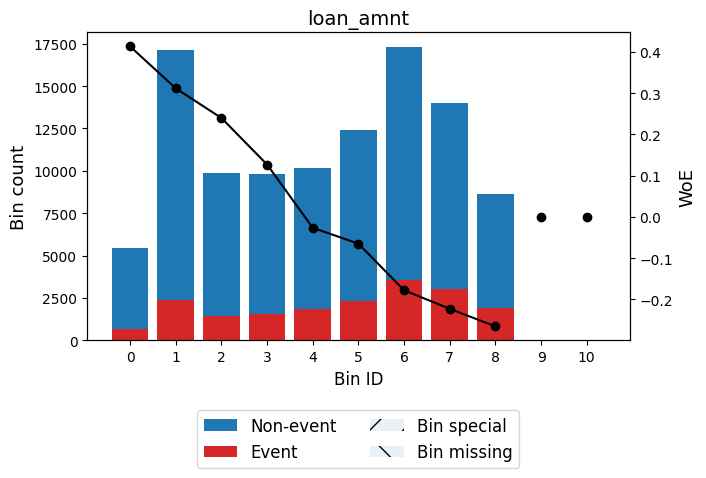


🔍 Feature: funded_amnt
✅ Total IV for funded_amnt: 0.0481
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3512.50)      │    5436 │             0.126  │ 0.41398606151226436  │ 0.00774884  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3512.50, 7012.50)   │   17159 │             0.1378 │ 0.3107381698093479   │ 0.01427     │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [7012.50, 9037.50)   │    9915 │             0.1461 │ 0.2424789773477547   │ 0.00513707  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [9037.50, 10062.50)  │    9787 │             0.161  │ 0.12787922587853262  │ 0.00146488  │
├──────────


🔍 Feature: term
✅ Total IV for term: 0.2084
╒═══════════════╤═════════╤════════════════════╤═════════════════════╤═══════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                 │        IV │
╞═══════════════╪═════════╪════════════════════╪═════════════════════╪═══════════╡
│ (-inf, 48.00) │   79815 │             0.1391 │ 0.30000301297936316 │ 0.0620935 │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ [48.00, inf)  │   24997 │             0.3066 │ -0.7068155098585461 │ 0.146294  │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Special       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Missing       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│               │  104812 │             0.


🔍 Feature: int_rate
✅ Total IV for int_rate: 0.4467
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 6.91)   │    7207 │             0.0375 │ 1.723497222974495    │ 0.114156    │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [6.91, 7.88)   │    5312 │             0.0582 │ 1.2617462331780276   │ 0.0525902   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [7.88, 8.21)   │    5955 │             0.0774 │ 0.9553083222461387   │ 0.0375321   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [8.21, 9.47)   │    7380 │             0.1005 │ 0.6685112477001076   │ 0.0251435   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────


🔍 Feature: installment
✅ Total IV for installment: 0.0400
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 130.96)   │    6646 │             0.122  │ 0.4506559891928117   │ 0.0110872   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [130.96, 200.98) │   11093 │             0.1326 │ 0.35540420024552954  │ 0.0118877   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [200.98, 251.60) │    8265 │             0.1474 │ 0.2326863236447485   │ 0.00395619  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [251.60, 338.55) │   18907 │             0.176  │ 0.021211541993830796 │ 8.06108e-05 │
├──────────────────┼─────────┼────────────────────┼


🔍 Feature: emp_length
✅ Total IV for emp_length: 0.0018
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │    8268 │             0.1848 │ -0.03860526723254498 │ 0.000119026 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 6.50) │   47942 │             0.1842 │ -0.03484758964310197 │ 0.000561682 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [6.50, 9.50) │   14013 │             0.1786 │ 0.003020708871722455 │ 1.21876e-06 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [9.50, inf)  │   34589 │             0.1707 │ 0.05803874934323128  │ 0.00109101  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Specia


🔍 Feature: annual_inc
✅ Total IV for annual_inc: 0.0217
╒════════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 32950.00)       │    9302 │             0.2054 │ -0.17006912286781817 │ 0.00270824  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [32950.00, 44927.43)   │   14116 │             0.2    │ -0.13632258594225077 │ 0.00261314  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [44927.43, 49519.75)   │    6651 │             0.1982 │ -0.12490700587428205 │ 0.00102998  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [49519.75, 60134.50)   │   18287 │             0.1917 │ -0.08383871568153878 │ 0.00125

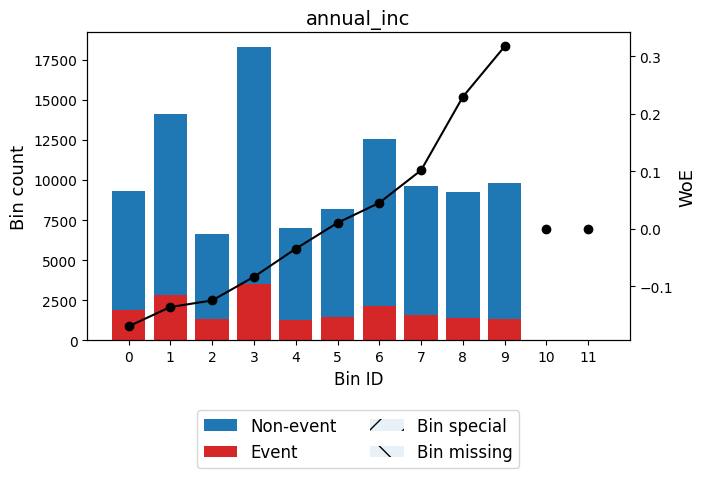


🔍 Feature: dti
✅ Total IV for dti: 0.0872
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 5.56)   │    6033 │             0.1144 │ 0.5241454729540345   │ 0.0132774   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.56, 9.30)   │   10253 │             0.1272 │ 0.4033998292838281   │ 0.0139274   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [9.30, 11.97)  │   10207 │             0.1361 │ 0.32550552175110736  │ 0.00926828  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [11.97, 13.69) │    7639 │             0.1465 │ 0.23973344519634154  │ 0.00387228  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤



🔍 Feature: delinq_2yrs
✅ Total IV for delinq_2yrs: 0.0029
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   84338 │             0.1757 │ 0.02298445388338033  │ 0.000421959 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50) │   13535 │             0.1857 │ -0.0442894845128432  │ 0.000256918 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, inf)  │    6939 │             0.2069 │ -0.17927357396084243 │ 0.00225124  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Miss


🔍 Feature: inq_last_6mths
✅ Total IV for inq_last_6mths: 0.0236
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │   59412 │             0.162  │ 0.12068452418965903  │ 0.00793882 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, 1.50) │   28690 │             0.1888 │ -0.06495376772566575 │ 0.00117902 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, 2.50) │   10814 │             0.2115 │ -0.20670881669316343 │ 0.00470384 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, inf)  │    5896 │             0.2441 │ -0.392178035353244   │ 0.00975503 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special  

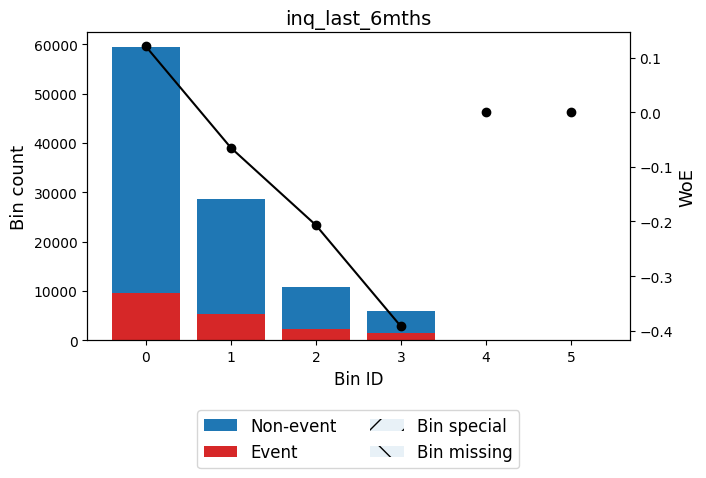


🔍 Feature: open_acc
✅ Total IV for open_acc: 0.0178
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 5.50)   │    8867 │             0.1472 │ 0.2342271632816526   │ 0.00429854  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, 6.50)   │    6488 │             0.1554 │ 0.1704314298983156   │ 0.00170089  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [6.50, 8.50)   │   16886 │             0.1607 │ 0.1305782110955418   │ 0.00263291  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [8.50, 10.50)  │   18543 │             0.1697 │ 0.06533537919926369  │ 0.000739439 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────

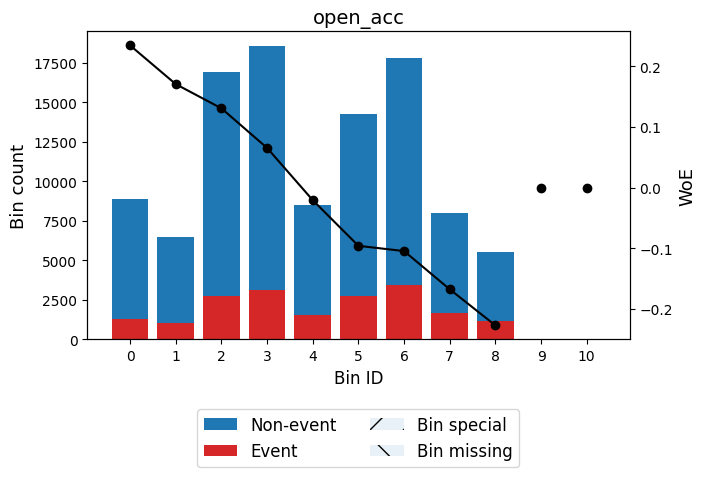


🔍 Feature: pub_rec
✅ Total IV for pub_rec: 0.0055
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   87523 │             0.1741 │ 0.03388046919662635  │ 0.000948139 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │   17289 │             0.204  │ -0.16124198188605865 │ 0.00451233  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│             


🔍 Feature: revol_bal
✅ Total IV for revol_bal: 0.0040
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 4944.50)      │   19043 │             0.1739 │ 0.035741094592022016  │ 0.000229436 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4944.50, 9350.50)   │   23355 │             0.1786 │ 0.0032152816579185117 │ 2.30122e-06 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [9350.50, 14827.50)  │   22069 │             0.1795 │ -0.003155845850285388 │ 2.09915e-06 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [14827.50, 19983.50) │   13454 │             0.1896 │ -0.0701529598478614   │ 0.000646011 │
├────

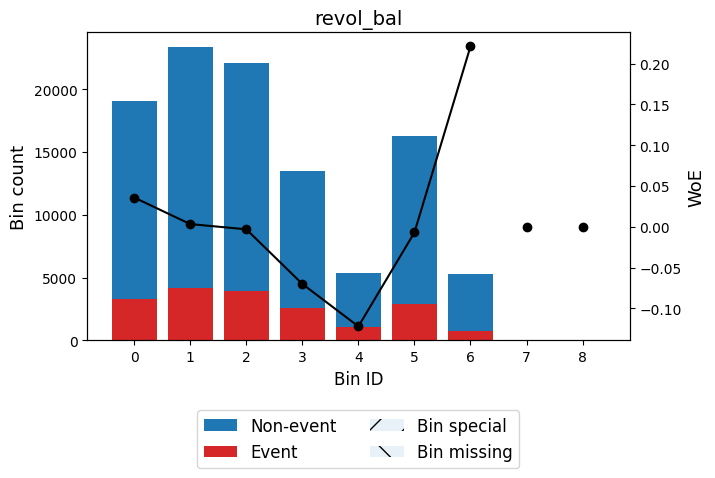


🔍 Feature: revol_util
✅ Total IV for revol_util: 0.0220
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 19.65)  │    9805 │             0.1311 │ 0.36895212108160935   │ 0.011272    │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [19.65, 26.25) │    5749 │             0.1503 │ 0.2096462942603956    │ 0.00225107  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [26.25, 37.05) │   12770 │             0.1635 │ 0.10964791048475453   │ 0.00141365  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [37.05, 46.05) │   12418 │             0.1749 │ 0.028533482032889745  │ 9.55789e-05 │
├────────────────┼─────────┼────────────────────┼──────────────

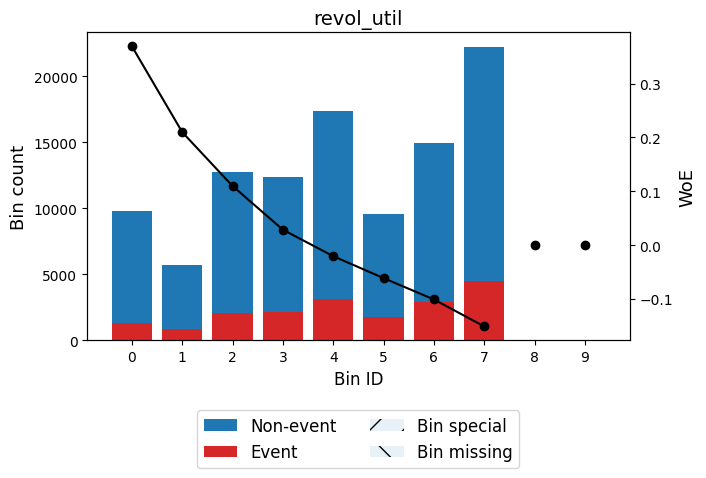


🔍 Feature: total_acc
✅ Total IV for total_acc: 0.0040
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 11.50)  │   10407 │             0.16   │ 0.13560837159628392  │ 0.00174723  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [11.50, 18.50) │   22726 │             0.1749 │ 0.02882176785254531  │ 0.000178453 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [18.50, 24.50) │   22472 │             0.1779 │ 0.008168885692647398 │ 1.42698e-05 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [24.50, 42.50) │   40141 │             0.182  │ -0.01957171630346477 │ 0.000147624 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼───

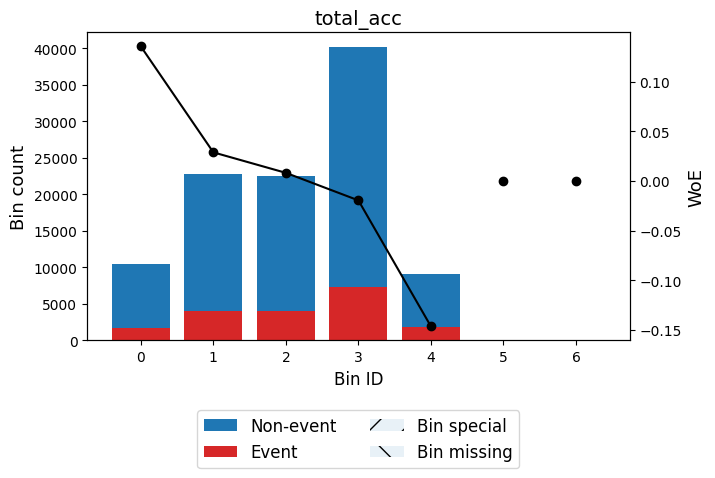


🔍 Feature: collections_12_mths_ex_med
✅ Total IV for collections_12_mths_ex_med: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104812 │             0.1791 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104812 │             0.1791 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛



🔍 Feature: acc_now_delinq
✅ Total IV for acc_now_delinq: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104812 │             0.1791 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104812 │             0.1791 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


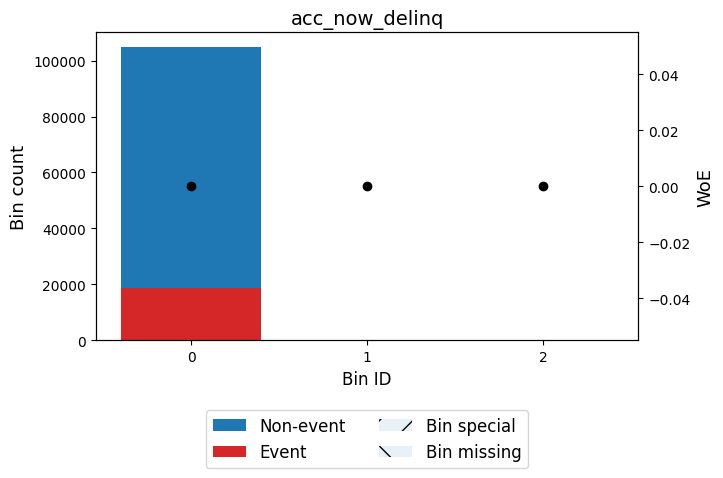


🔍 Feature: tot_cur_bal
✅ Total IV for tot_cur_bal: 0.0306
╒════════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 13183.00)       │    8537 │             0.1584 │ 0.1477050404977842   │ 0.00169363  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [13183.00, 21307.00)   │    7883 │             0.1874 │ -0.0554834537747082  │ 0.000235666 │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [21307.00, 27510.50)   │    6038 │             0.1969 │ -0.11704562099786142 │ 0.000819042 │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [27510.50, 40415.50)   │   10429 │             0.2069 │ -0.17913194753860529 │ 0.003


🔍 Feature: total_rev_hi_lim
✅ Total IV for total_rev_hi_lim: 0.0178
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 7508.00)      │    7839 │             0.2044 │ -0.1634590525146138  │ 0.00210403  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [7508.00, 23921.00)  │   41222 │             0.1925 │ -0.08913402646850344 │ 0.0032145   │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [23921.00, 38078.00) │   28889 │             0.1757 │ 0.023002598777232874 │ 0.000144764 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [38078.00, 50325.00) │   10657 │             0.1729 │ 0.042241186319677215 │ 0.000178972 │
├

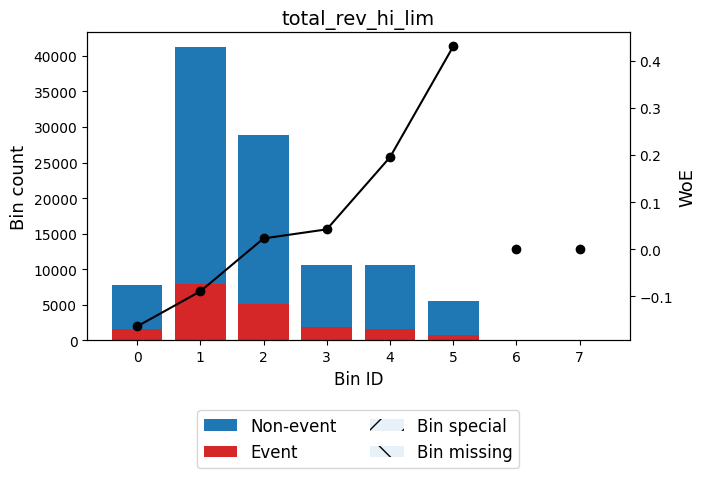


🔍 Feature: acc_open_past_24mths
✅ Total IV for acc_open_past_24mths: 0.0827
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 1.50) │   13546 │             0.1211 │ 0.4596407314826596   │ 0.0234363   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 2.50) │   13315 │             0.1416 │ 0.27899029929176344  │ 0.00902176  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 3.50) │   14955 │             0.1572 │ 0.15646795292466398  │ 0.00331975  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 4.50) │   18727 │             0.1649 │ 0.09953866087911689  │ 0.0017141   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───

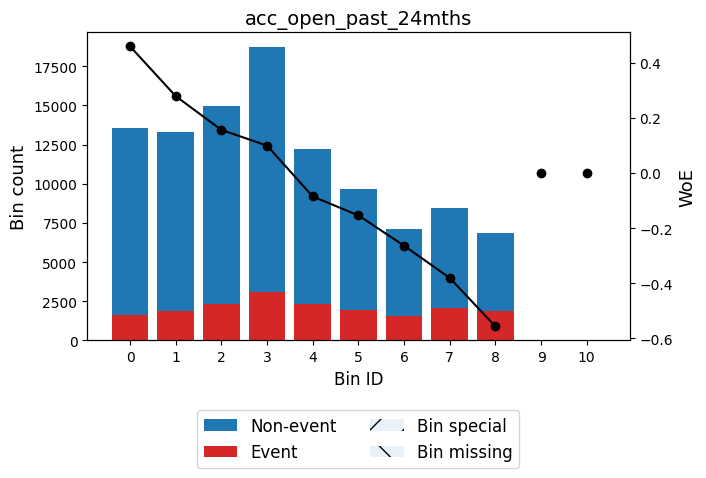


🔍 Feature: avg_cur_bal
✅ Total IV for avg_cur_bal: 0.0392
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 1534.50)      │    8463 │             0.1817 │ -0.01805032042248178 │ 2.64603e-05 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1534.50, 2361.50)   │    8495 │             0.2009 │ -0.14228659785275544 │ 0.00171638  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2361.50, 3234.50)   │    8647 │             0.2057 │ -0.17188396706090092 │ 0.002573    │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3234.50, 3921.50)   │    5951 │             0.2193 │ -0.252901907838871   │ 0.00392949  │
├──────────

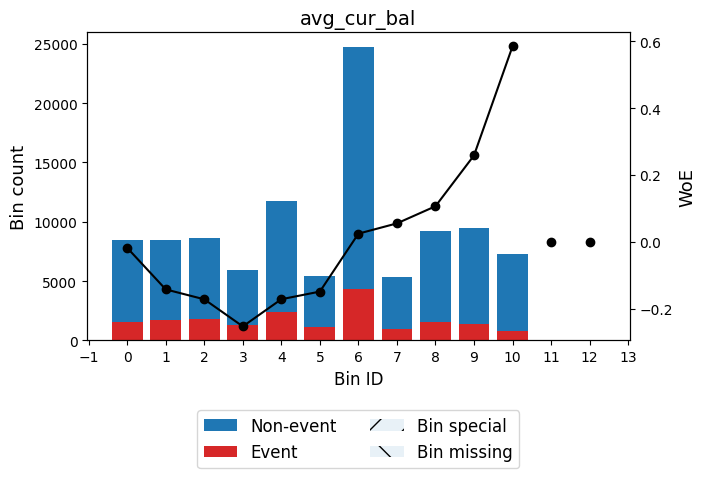


🔍 Feature: bc_open_to_buy
✅ Total IV for bc_open_to_buy: 0.0540
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 372.50)       │   10407 │             0.2293 │ -0.31026072270336846 │ 0.0105214  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [372.50, 880.50)     │    8518 │             0.2084 │ -0.18800099458736597 │ 0.00304731 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [880.50, 1899.50)    │   11793 │             0.2042 │ -0.16238935882053407 │ 0.00312297 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1899.50, 2693.50)   │    7499 │             0.1976 │ -0.12150923204811215 │ 0.00109782 │
├──────────────

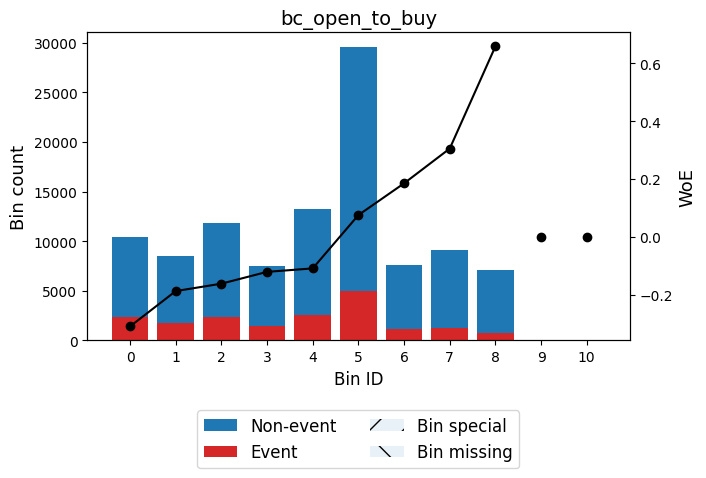


🔍 Feature: bc_util
✅ Total IV for bc_util: 0.0304
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 21.35)  │    9812 │             0.1399 │ 0.29316018997756377  │ 0.00730593  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [21.35, 42.85) │   16266 │             0.1524 │ 0.19316536472400658  │ 0.00543672  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [42.85, 63.95) │   27066 │             0.1669 │ 0.08513716098247559  │ 0.00182091  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [63.95, 79.95) │   19047 │             0.1882 │ -0.06107857456573251 │ 0.000691279 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼───────

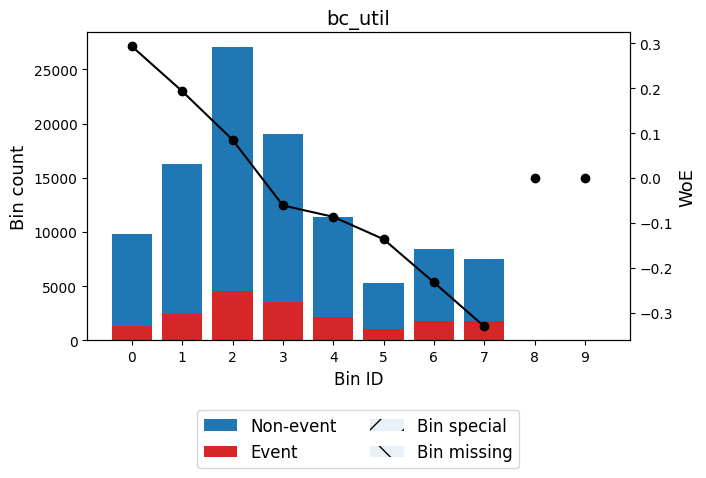


🔍 Feature: chargeoff_within_12_mths
✅ Total IV for chargeoff_within_12_mths: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104812 │             0.1791 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104812 │             0.1791 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


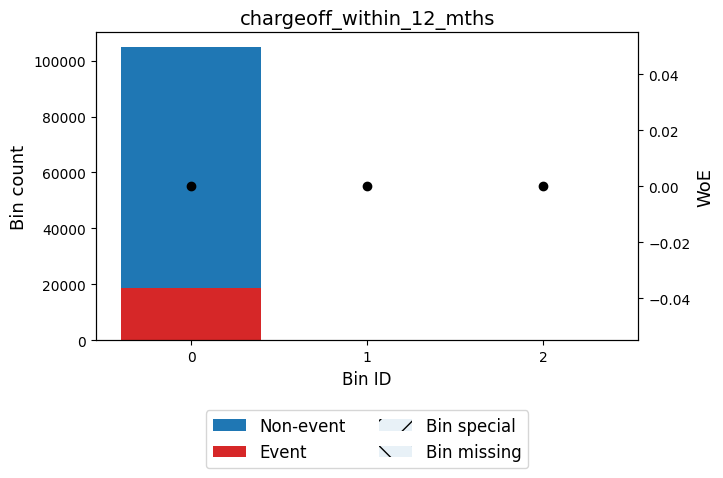


🔍 Feature: delinq_amnt
✅ Total IV for delinq_amnt: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104812 │             0.1791 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104812 │             0.1791 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


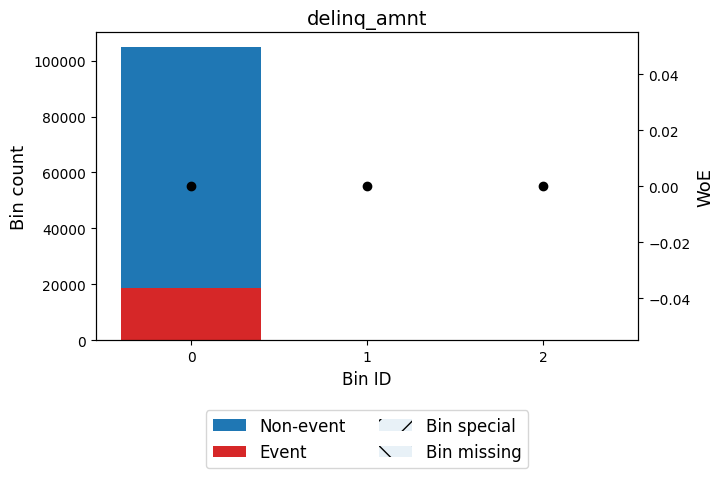


🔍 Feature: mo_sin_old_il_acct
✅ Total IV for mo_sin_old_il_acct: 0.0074
╒══════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 78.50)    │   15578 │             0.1964 │ -0.11354607630367286  │ 0.00198647  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [78.50, 128.50)  │   31043 │             0.1829 │ -0.025718730955783142 │ 0.000197527 │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [128.50, 129.50) │   10580 │             0.1476 │ 0.23055002716896644   │ 0.00497529  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [129.50, 208.50) │   42366 │             0.1768 │ 0.015362438763352193  │ 9.49254e-05 │
├──────────────────┼───────

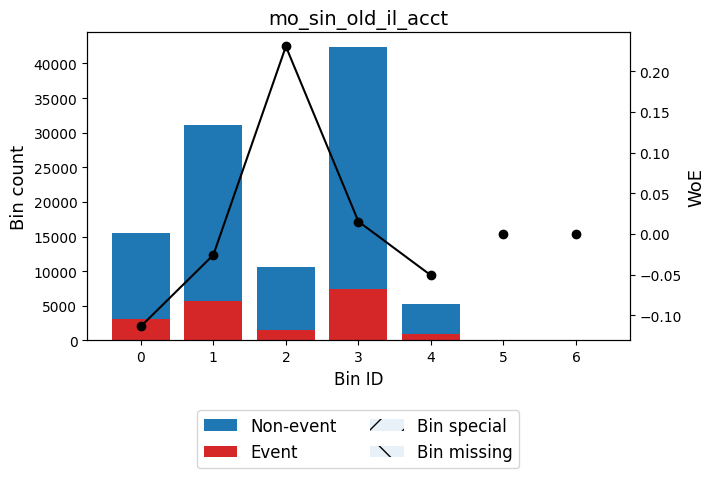


🔍 Feature: mo_sin_old_rev_tl_op
✅ Total IV for mo_sin_old_rev_tl_op: 0.0150
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 62.50)    │    5898 │             0.2185 │ -0.24856131163111095 │ 0.00375703  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [62.50, 111.50)  │   15157 │             0.2001 │ -0.1370707709233192  │ 0.00283739  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [111.50, 122.50) │    5470 │             0.198  │ -0.12379484724720835 │ 0.000831785 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [122.50, 144.50) │   11700 │             0.1885 │ -0.06322640211461628 │ 0.000455331 │
├──────────────────┼─────────┼───

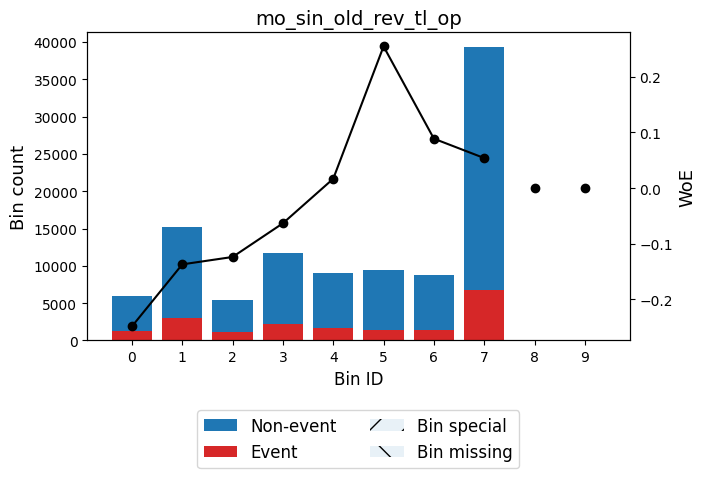


🔍 Feature: mo_sin_rcnt_rev_tl_op
✅ Total IV for mo_sin_rcnt_rev_tl_op: 0.0291
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50)   │    7893 │             0.2197 │ -0.2552219530658757   │ 0.00531159  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50)   │    8006 │             0.2093 │ -0.19381526731623833  │ 0.00304947  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50)   │    7693 │             0.1975 │ -0.12041079894610007  │ 0.00110557  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 4.50)   │    6832 │             0.1947 │ -0.10277278114371136  │ 0.000711319 │
├────────────────┼─────────┼─────────────

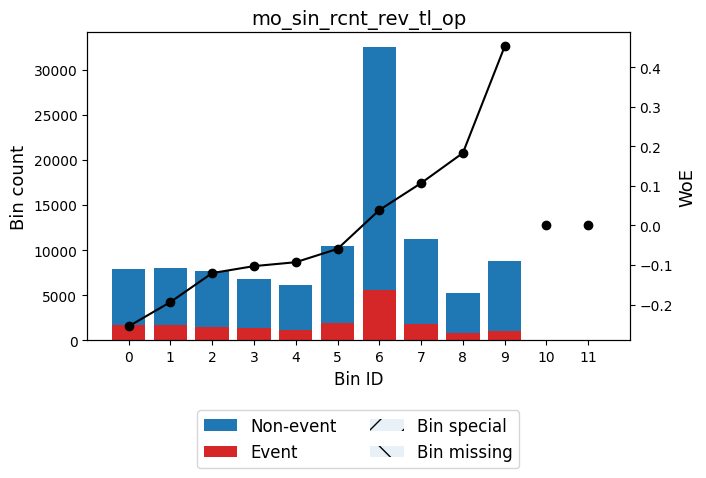


🔍 Feature: mo_sin_rcnt_tl
✅ Total IV for mo_sin_rcnt_tl: 0.0387
╒════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 1.50)   │    9908 │             0.2213 │ -0.26480948503305846 │ 0.00719869 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, 2.50)   │   10967 │             0.2171 │ -0.2400930991147887  │ 0.00650141 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, 3.50)   │   10562 │             0.1988 │ -0.12905729384393338 │ 0.00174841 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [3.50, 4.50)   │    9261 │             0.1954 │ -0.10768409511857557 │ 0.00106021 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼───

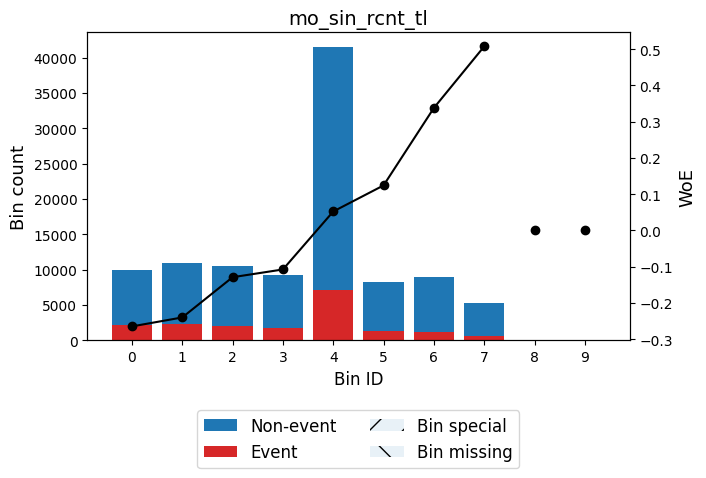


🔍 Feature: mort_acc
✅ Total IV for mort_acc: 0.0202
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   39758 │             0.203  │ -0.15476544276966653 │ 0.00954061  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50) │   21505 │             0.1742 │ 0.033498324238129706 │ 0.000227767 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 2.50) │   14646 │             0.17   │ 0.06283466316549857  │ 0.000540625 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 3.50) │   10872 │             0.1664 │ 0.08872048324705473  │ 0.000793371 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 5.5

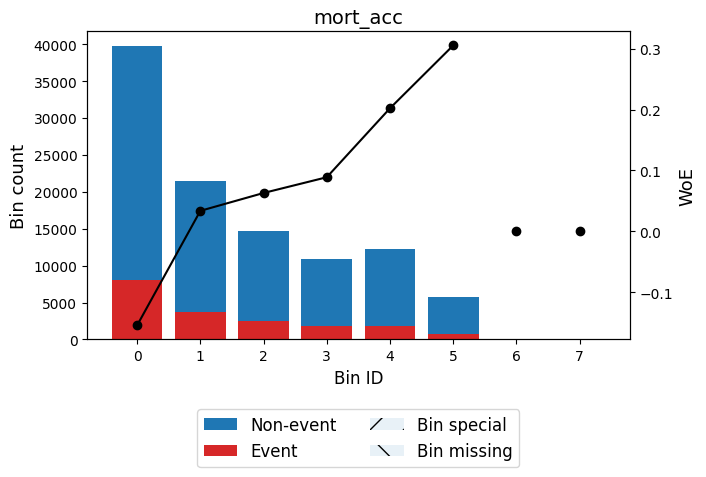


🔍 Feature: mths_since_recent_bc
✅ Total IV for mths_since_recent_bc: 0.0251
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 2.50)   │    8676 │             0.2205 │ -0.2599116132777446  │ 0.00606361  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 4.50)   │    9507 │             0.202  │ -0.1485944310961842  │ 0.00209904  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4.50, 9.50)   │   19298 │             0.1938 │ -0.09688444807458296 │ 0.00178229  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [9.50, 11.50)  │    6157 │             0.1907 │ -0.07709010351906875 │ 0.000357779 │
├────────────────┼─────────┼────────────────────┼────

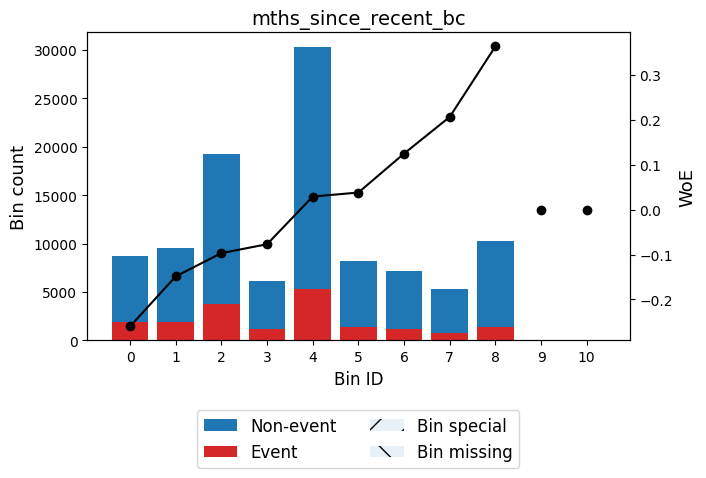


🔍 Feature: mths_since_recent_inq
✅ Total IV for mths_since_recent_inq: 0.0279
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 2.50) │   26778 │             0.213  │ -0.2158331313470907  │ 0.0127342  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, 3.50) │    7320 │             0.2001 │ -0.1372647468317818  │ 0.00137427 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [3.50, 4.50) │    6715 │             0.1894 │ -0.06896558687829923 │ 0.00031149 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [4.50, 5.50) │   20576 │             0.1449 │ 0.2526504546651822   │ 0.0115346  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───────────

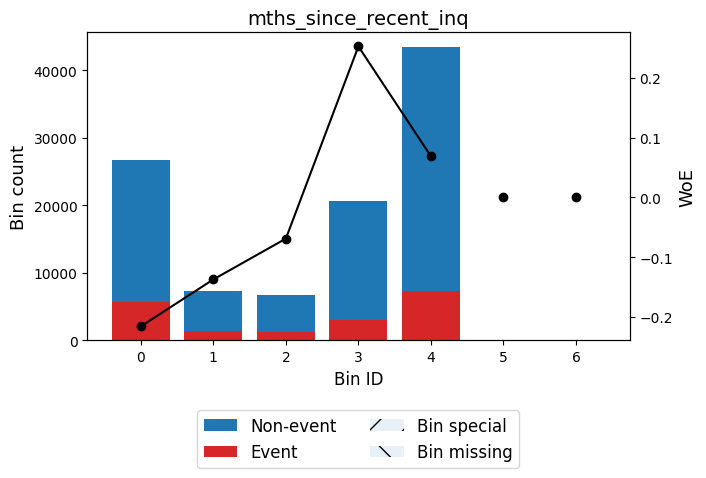


🔍 Feature: num_accts_ever_120_pd
✅ Total IV for num_accts_ever_120_pd: 0.0037
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   81497 │             0.1742 │ 0.033338766669652076 │ 0.000855003 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │   23315 │             0.196  │ -0.11129165613066982 │ 0.00285418  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─

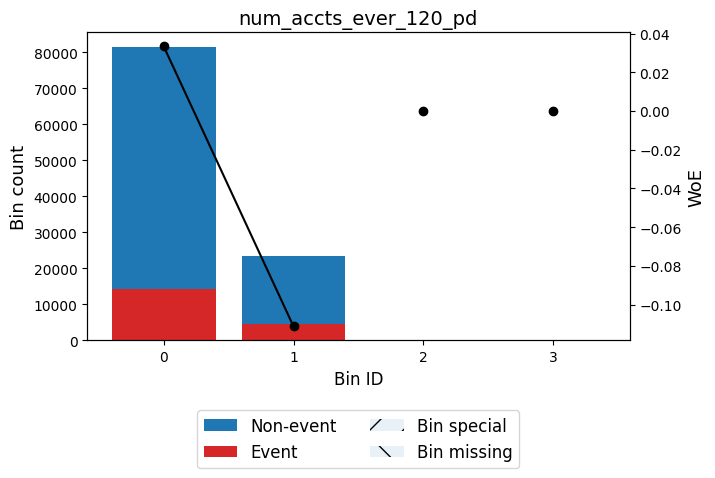


🔍 Feature: num_actv_bc_tl
✅ Total IV for num_actv_bc_tl: 0.0121
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50) │   12332 │             0.1774 │ 0.011189011722703368  │ 1.46773e-05 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50) │   19863 │             0.1688 │ 0.07176414141742704   │ 0.000953625 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50) │   27865 │             0.1626 │ 0.11652693849440432   │ 0.00347602  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 4.50) │   16801 │             0.1802 │ -0.007494774329506848 │ 9.02579e-06 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼────

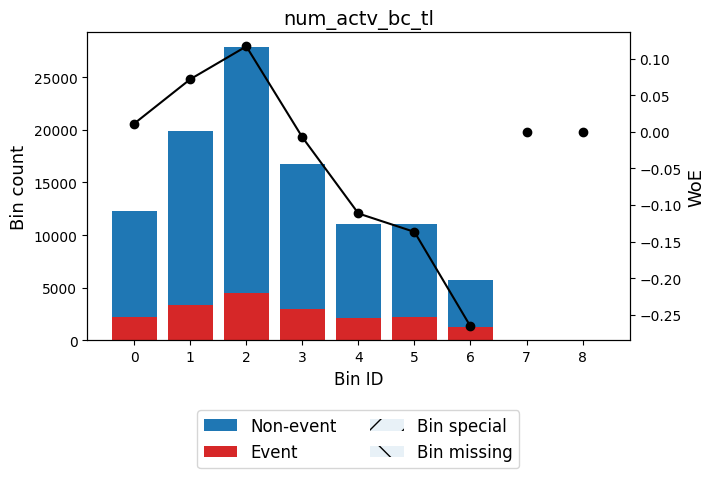


🔍 Feature: num_actv_rev_tl
✅ Total IV for num_actv_rev_tl: 0.0333
╒═══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                  │          IV │
╞═══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 2.50)  │   11532 │             0.1471 │ 0.235071085571803    │ 0.00562925  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 4.50)  │   28744 │             0.1596 │ 0.13838309576609875  │ 0.00502074  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4.50, 5.50)  │   20856 │             0.1657 │ 0.09365285386624245  │ 0.00169314  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, 6.50)  │   11805 │             0.1853 │ -0.04216102024182189 │ 0.000202922 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼──

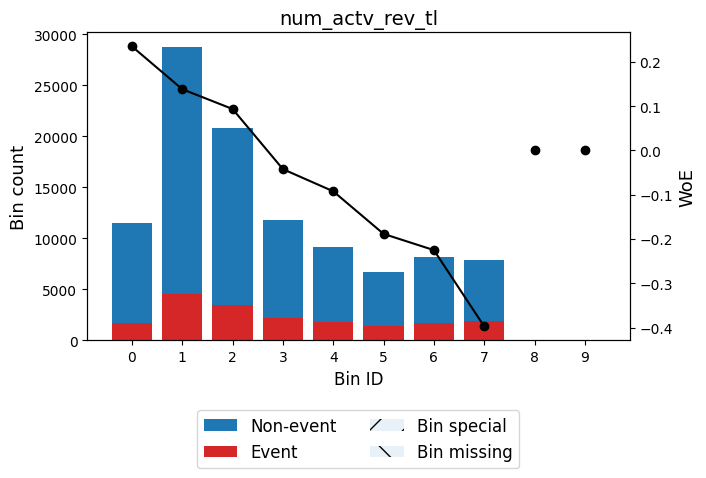


🔍 Feature: num_bc_sats
✅ Total IV for num_bc_sats: 0.0044
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50) │    6979 │             0.1877 │ -0.057719903283325324 │ 0.00022596  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 3.50) │   31219 │             0.1755 │ 0.024196749002092233  │ 0.000173038 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 4.50) │   22301 │             0.1645 │ 0.10225588579646328   │ 0.00215229  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4.50, 6.50) │   23496 │             0.1828 │ -0.025479579585259593 │ 0.000146727 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼──────────

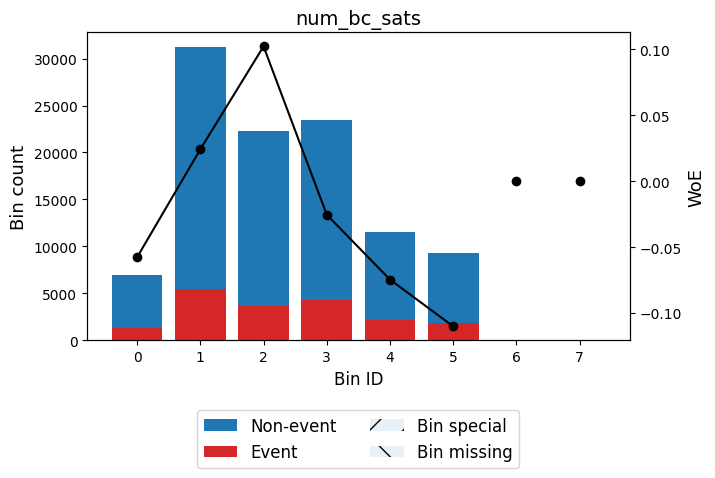


🔍 Feature: num_bc_tl
✅ Total IV for num_bc_tl: 0.0047
╒═══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 2.50)  │    5918 │             0.2009 │ -0.14210435545933775  │ 0.00119258  │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50)  │    6761 │             0.1867 │ -0.05083700800577562  │ 0.000169437 │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 5.50)  │   18267 │             0.1817 │ -0.017791522527031756 │ 5.54827e-05 │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [5.50, 6.50)  │    9880 │             0.1814 │ -0.015656334247000192 │ 2.32223e-05 │
├───────────────┼─────────┼────────────────────┼───────────────────────┼───

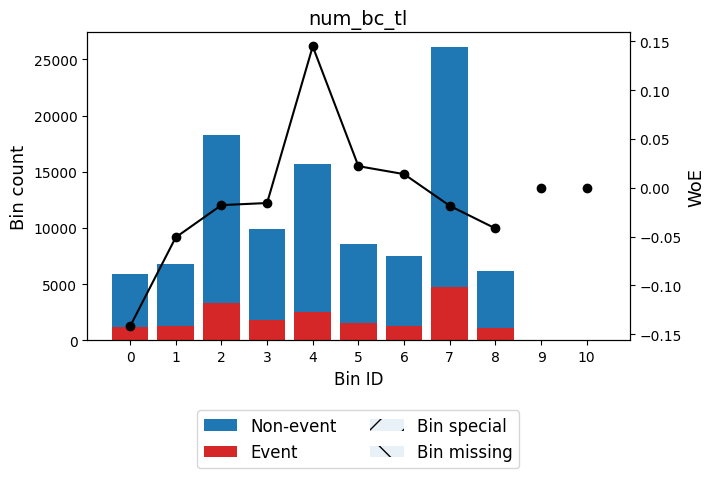


🔍 Feature: num_il_tl
✅ Total IV for num_il_tl: 0.0084
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 2.50)   │   16114 │             0.1615 │ 0.12459229800275362  │ 0.00229196  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 7.50)   │   45414 │             0.172  │ 0.04884533640646738  │ 0.00101762  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [7.50, 10.50)  │   15450 │             0.1842 │ -0.0346057771850643  │ 0.000178493 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [10.50, 21.50) │   21835 │             0.1937 │ -0.09643130686406876 │ 0.00199749  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼───


🔍 Feature: num_op_rev_tl
✅ Total IV for num_op_rev_tl: 0.0174
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 6.50)   │   39028 │             0.1641 │ 0.10560673369376072   │ 0.00401313  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [6.50, 7.50)   │   16867 │             0.1571 │ 0.1576210558049269    │ 0.00379812  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7.50, 8.50)   │    9457 │             0.1875 │ -0.056238283598192496 │ 0.000290536 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [8.50, 9.50)   │    7979 │             0.1895 │ -0.06942645670531733  │ 0.000375142 │
├────────────────┼─────────┼────────────────────┼────────

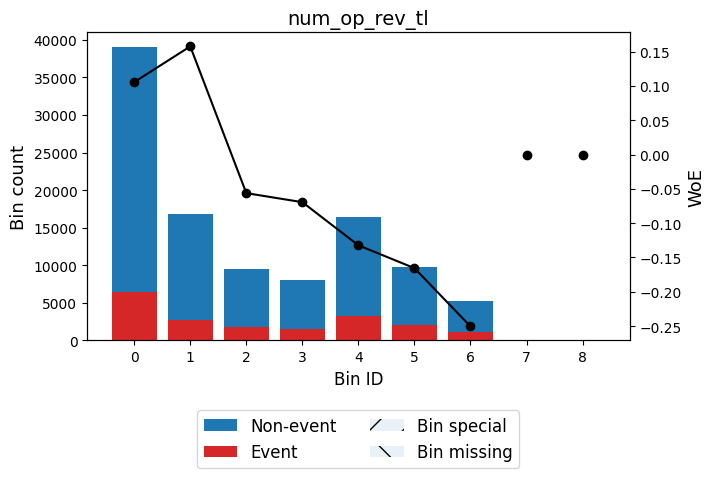


🔍 Feature: num_rev_accts
✅ Total IV for num_rev_accts: 0.0055
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 5.50)   │    7411 │             0.1776 │ 0.010166428617677692 │ 7.28424e-06 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, 11.50)  │   31131 │             0.1767 │ 0.016348962741202344 │ 7.89733e-05 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [11.50, 12.50) │    5603 │             0.1728 │ 0.043453889310946625 │ 9.9537e-05  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [12.50, 13.50) │   11909 │             0.1542 │ 0.17956378334981338  │ 0.00345515  │
├────────────────┼─────────┼────────────────────┼──────────────────


🔍 Feature: num_rev_tl_bal_gt_0
✅ Total IV for num_rev_tl_bal_gt_0: 0.0320
╒═══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 2.50)  │   11572 │             0.1474 │ 0.23223755232962717   │ 0.00551863  │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50)  │   13610 │             0.1599 │ 0.1363975424356514    │ 0.00231105  │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 4.50)  │   15226 │             0.1607 │ 0.1302349127536       │ 0.00236188  │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4.50, 5.50)  │   21004 │             0.1653 │ 0.09659148434602738   │ 0.0018121   │
├───────────────┼─────────┼────────────────────┼───────

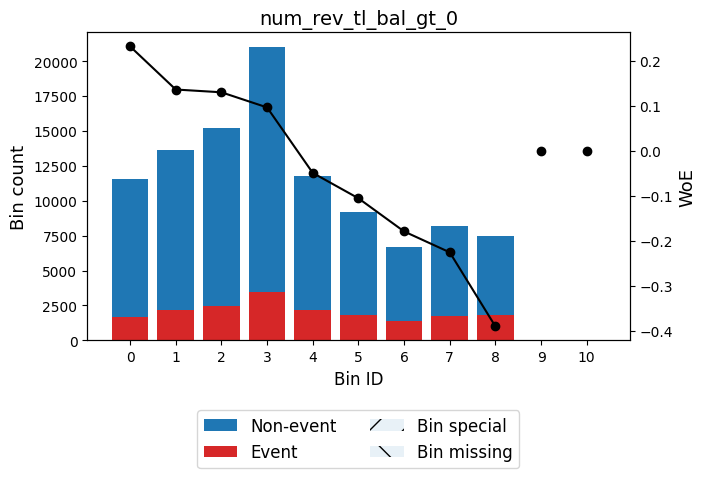


🔍 Feature: num_sats
✅ Total IV for num_sats: 0.0177
╒════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 5.50)   │    8085 │             0.1482 │ 0.22627657545687163  │ 0.00366758 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [5.50, 6.50)   │    6027 │             0.1575 │ 0.154558462242264    │ 0.00130625 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [6.50, 8.50)   │   15945 │             0.1618 │ 0.1221444492449244   │ 0.00218144 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [8.50, 11.50)  │   31138 │             0.1698 │ 0.06416499699262124  │ 0.00119806 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│

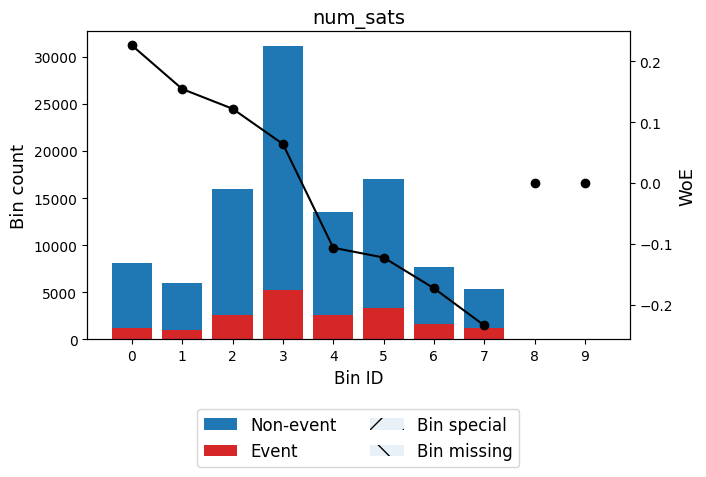


🔍 Feature: num_tl_120dpd_2m
✅ Total IV for num_tl_120dpd_2m: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104812 │             0.1791 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104812 │             0.1791 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


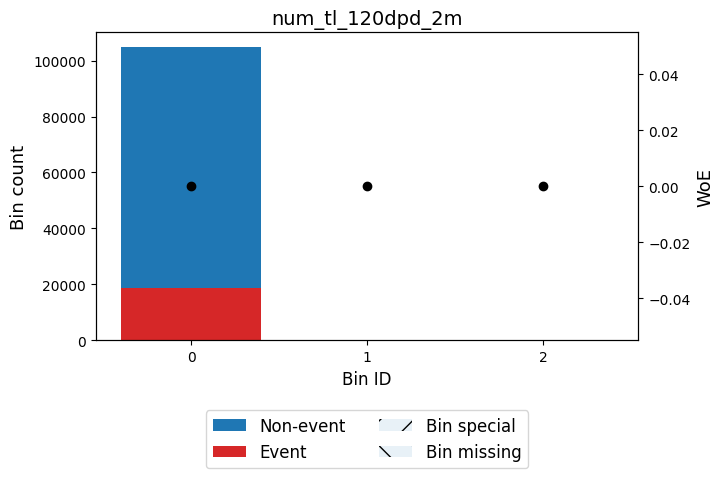


🔍 Feature: num_tl_30dpd
✅ Total IV for num_tl_30dpd: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104812 │             0.1791 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104812 │             0.1791 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


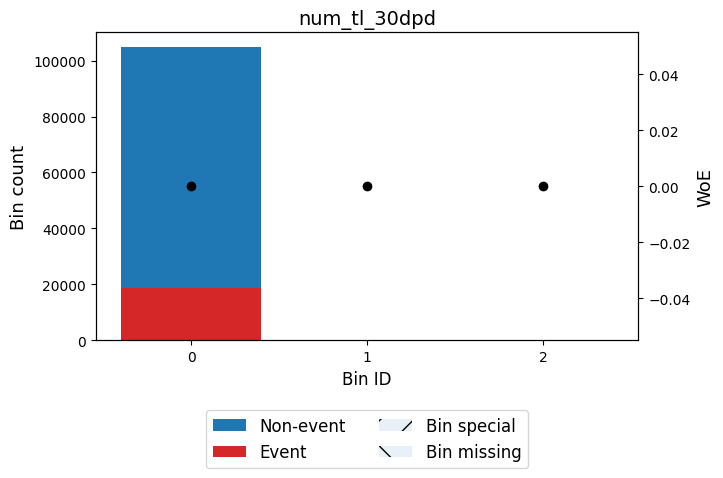


🔍 Feature: num_tl_90g_dpd_24m
✅ Total IV for num_tl_90g_dpd_24m: 0.0011
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   99119 │             0.1779 │ 0.008229538616090215 │ 6.38776e-05 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │    5693 │             0.2001 │ -0.13685021823592902 │ 0.00106223  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───────

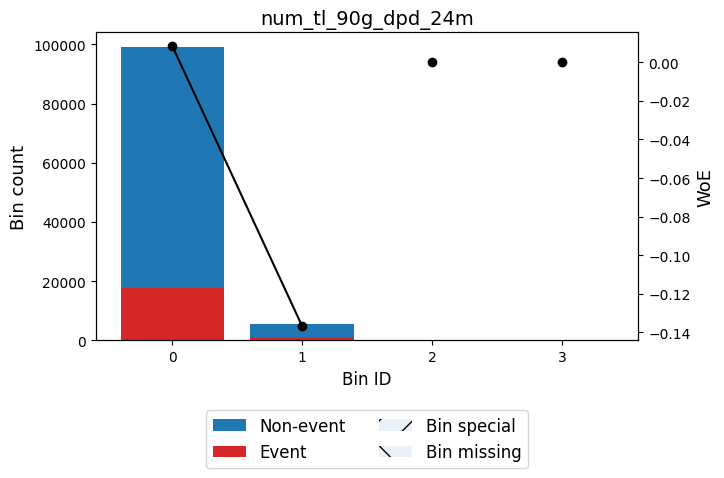


🔍 Feature: num_tl_op_past_12m
✅ Total IV for num_tl_op_past_12m: 0.0585
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   16750 │             0.1337 │ 0.3461721434799063   │ 0.0170827   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50) │   24621 │             0.1552 │ 0.17204513844377534  │ 0.00657393  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 2.50) │   29061 │             0.1708 │ 0.056927052707915315 │ 0.000882183 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 3.50) │   16281 │             0.2082 │ -0.1870060293438227  │ 0.00576126  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───────

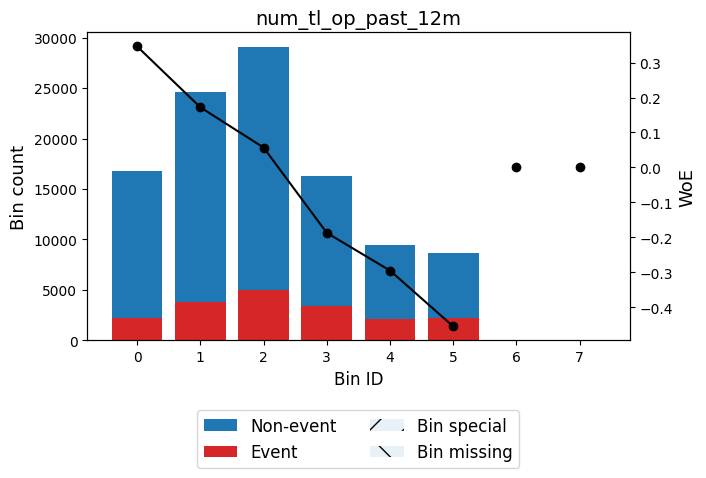


🔍 Feature: pct_tl_nvr_dlq
✅ Total IV for pct_tl_nvr_dlq: 0.0062
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 93.85)  │   32402 │             0.1904 │ -0.0754242997873813  │ 0.00180142  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [93.85, 96.85) │   13178 │             0.1898 │ -0.07130425811174845 │ 0.000653936 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [96.85, 97.85) │   10472 │             0.1534 │ 0.18577161938586007  │ 0.00324527  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [97.85, inf)   │   48760 │             0.1741 │ 0.033869661743950674 │ 0.000527883 │
├────────────────┼─────────┼────────────────────┼────────────────

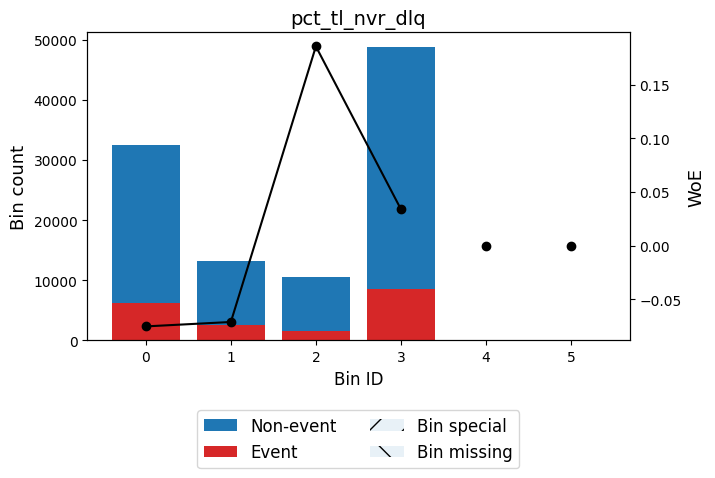


🔍 Feature: percent_bc_gt_75
✅ Total IV for percent_bc_gt_75: 0.0297
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 6.05)   │   21319 │             0.1455 │ 0.24760265788191305   │ 0.0114977   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [6.05, 31.25)  │   14276 │             0.1633 │ 0.11130991931172107   │ 0.00162775  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [31.25, 43.30) │   17023 │             0.1639 │ 0.1068161148427822    │ 0.00179003  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [43.30, 52.75) │   11962 │             0.1827 │ -0.024848488737538865 │ 7.10309e-05 │
├────────────────┼─────────┼────────────────────┼──

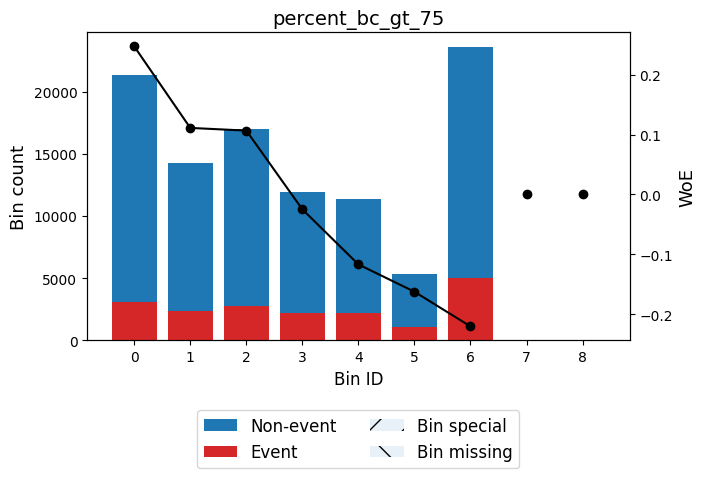


🔍 Feature: pub_rec_bankruptcies
✅ Total IV for pub_rec_bankruptcies: 0.0038
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   92397 │             0.1757 │ 0.023361415085256798 │ 0.000477509 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │   12415 │             0.2044 │ -0.1638730487786375  │ 0.00334958  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───

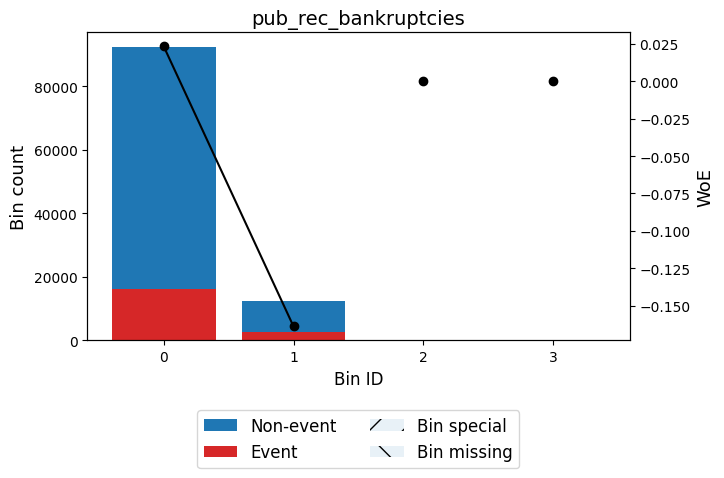


🔍 Feature: tax_liens
✅ Total IV for tax_liens: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104812 │             0.1791 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104812 │             0.1791 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


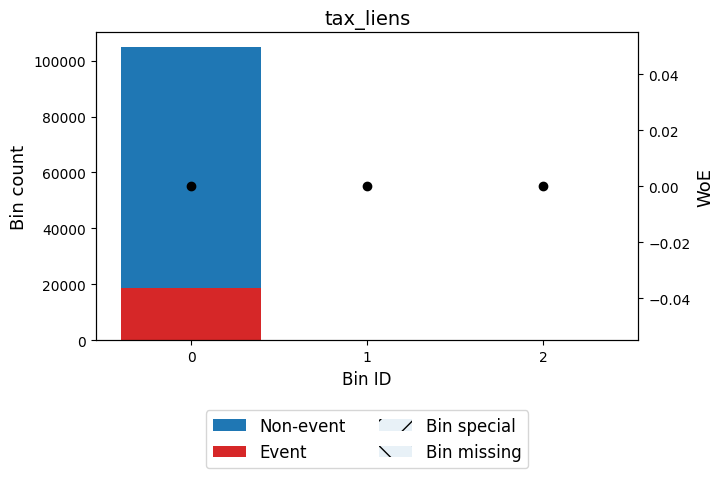


🔍 Feature: tot_hi_cred_lim
✅ Total IV for tot_hi_cred_lim: 0.0303
╒════════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 24641.50)       │    7998 │             0.1752 │ 0.026723231473432252 │ 5.40274e-05 │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [24641.50, 44803.00)   │   13561 │             0.1981 │ -0.12429202253872984 │ 0.00207905  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [44803.00, 55088.50)   │    6597 │             0.2033 │ -0.15675082452966382 │ 0.00162494  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [55088.50, 64958.00)   │    5264 │             0.2158 │ -0.2324257935321299 

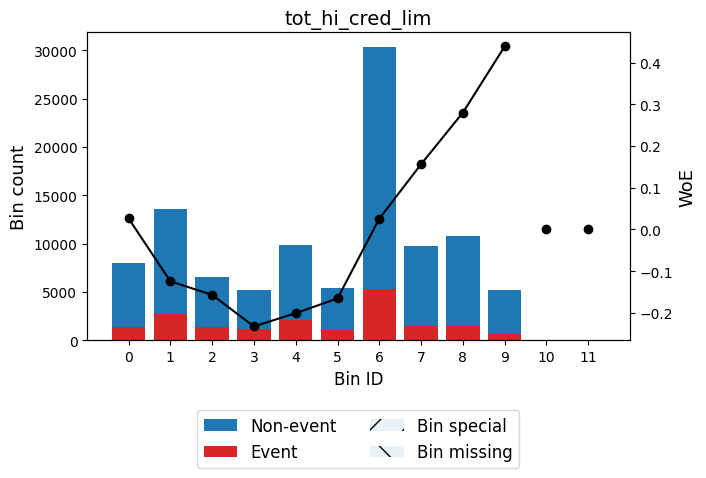


🔍 Feature: total_bal_ex_mort
✅ Total IV for total_bal_ex_mort: 0.0101
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 7887.50)      │    5754 │             0.1422 │ 0.2747427275700449   │ 0.00378628  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [7887.50, 13263.50)  │    7086 │             0.1504 │ 0.20846843216464528  │ 0.00274457  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [13263.50, 37345.00) │   41737 │             0.1745 │ 0.03137673437596744  │ 0.000388096 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [37345.00, 48845.50) │   13805 │             0.188  │ -0.05996027321531705 │ 0.000482679 │


🔍 Feature: total_bc_limit
✅ Total IV for total_bc_limit: 0.0310
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 4515.00)      │   12625 │             0.215  │ -0.22795310645643374  │ 0.00672177  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4515.00, 7720.00)   │   12761 │             0.2023 │ -0.15094301936667964  │ 0.00290937  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7720.00, 9452.50)   │    6527 │             0.1995 │ -0.13315224734793452  │ 0.00115159  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [9452.50, 11262.50)  │    6683 │             0.1947 │ -0.10277864863808595  │ 0.0006958


🔍 Feature: total_il_high_credit_limit
✅ Total IV for total_il_high_credit_limit: 0.0100
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 493.50)       │   12376 │             0.1463 │ 0.24160895205195798  │ 0.00636806  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [493.50, 35079.50)   │   48377 │             0.1756 │ 0.023884634637848068 │ 0.000261293 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [35079.50, 45068.50) │   10875 │             0.1898 │ -0.07135040814715543 │ 0.00054036  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [45068.50, 83753.00) │   21808 │             0.191  │ -0.079082672885309


🔍 Feature: credit_history_years
✅ Total IV for credit_history_years: 0.0030
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 11.50)  │   31222 │             0.1899 │ -0.07203338852901409  │ 0.00158155  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [11.50, 13.50) │   14877 │             0.1801 │ -0.006877088100638806 │ 6.72777e-06 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [13.50, 18.50) │   27746 │             0.1768 │ 0.015596572236738604  │ 6.40723e-05 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [18.50, 20.50) │    7647 │             0.1691 │ 0.06941393464517231   │ 0.000343743 │
├────────────────┼─────────┼───────────────


🔍 Feature: fico_score
✅ Total IV for fico_score: 0.1179
╒══════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 664.50)   │    9369 │             0.2376 │ -0.3567788980929496   │ 0.0126979   │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [664.50, 669.50) │    9265 │             0.2249 │ -0.2855559761753719   │ 0.00787642  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [669.50, 674.50) │    9221 │             0.2216 │ -0.26610402452250104  │ 0.00676784  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [674.50, 684.50) │   16539 │             0.2091 │ -0.19223509296744057  │ 0.00619438  │
├──────────────────┼─────────┼─────────────


🔍 Feature: fico_score/delinq_2yrs
✅ Total IV for fico_score/delinq_2yrs: 0.1036
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 228.17)   │    5547 │             0.2153 │ -0.22914925381268159 │ 0.00298548  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [228.17, 674.50) │   34511 │             0.2112 │ -0.2048724571411653  │ 0.0147377   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [674.50, 684.50) │   12428 │             0.2101 │ -0.19832321441903922 │ 0.00496343  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [684.50, 689.50) │    5707 │             0.191  │ -0.07913805412863217 │ 0.00034971  │
├──────────────────┼─────────

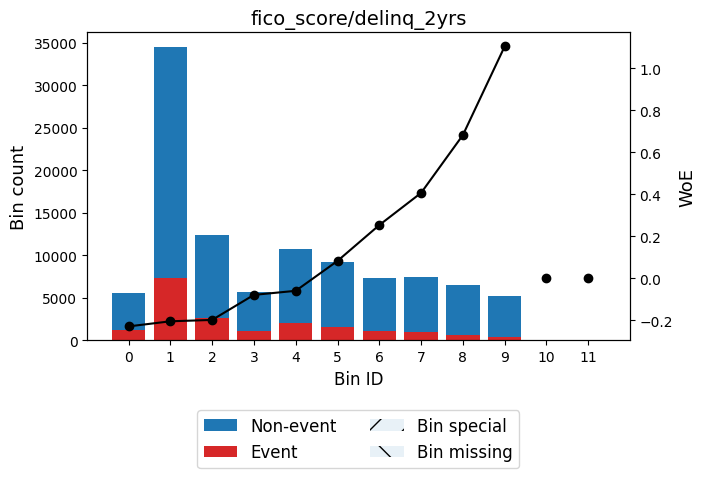


🔍 Feature: fico_score/acc_now_delinq
✅ Total IV for fico_score/acc_now_delinq: 0.1179
╒══════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 664.50)   │    9770 │             0.2366 │ -0.35153117046593363  │ 0.012835    │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [664.50, 669.50) │    9178 │             0.2243 │ -0.282158663336348    │ 0.00761018  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [669.50, 674.50) │    9159 │             0.2213 │ -0.2646706688814007   │ 0.00664725  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [674.50, 684.50) │   16424 │             0.2093 │ -0.19372355428679433  │ 0.00624979  │
├────────────


🔍 Feature: fico_score/inq_last_6mths
✅ Total IV for fico_score/inq_last_6mths: 0.0983
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 224.83)   │    9330 │             0.2468 │ -0.4071582500409192  │ 0.0167103   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [224.83, 342.25) │   20344 │             0.2136 │ -0.21920503984321216 │ 0.00998947  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [342.25, 354.75) │    8576 │             0.1902 │ -0.07387684884500145 │ 0.000457203 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [354.75, 684.50) │   30279 │             0.1862 │ -0.04804110757215785 │ 0.000677049 │
├──────────────────┼───


🔍 Feature: delinq_2yrs/credit_hist
✅ Total IV for delinq_2yrs/credit_hist: 0.0041
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.04) │   87004 │             0.1755 │ 0.024686958476856757  │ 0.000501897 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.04, 0.10) │   10742 │             0.1857 │ -0.044638767316540706 │ 0.000207153 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.10, inf)  │    7066 │             0.2133 │ -0.2174081850854579   │ 0.00341108  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                   │ 0           │
├──────────────┼─────────┼────────────────────┼──────────

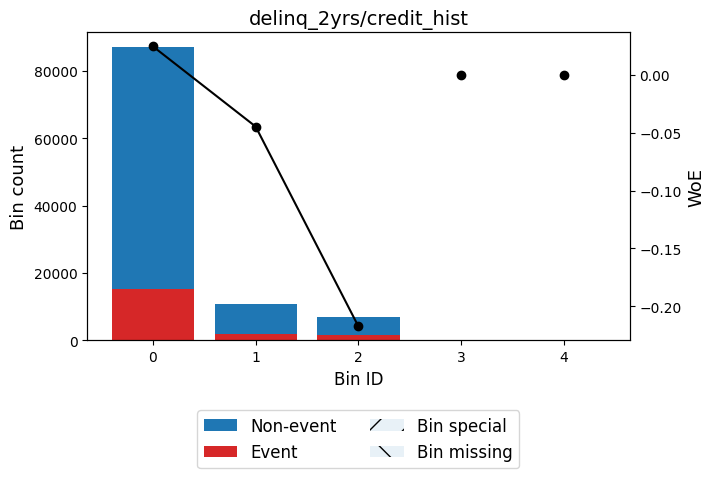


🔍 Feature: inq_last6mths_x_tl_op_past_12m
✅ Total IV for inq_last6mths_x_tl_op_past_12m: 0.0359
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   63096 │             0.1617 │ 0.12323449993595648  │ 0.00878378  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50) │    6042 │             0.1701 │ 0.061913331290696316 │ 0.000216599 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 2.50) │   10053 │             0.1762 │ 0.019834624910247234 │ 3.74941e-05 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 4.50) │   12389 │             0.2061 │ -0.1739255153178323  │ 0.00377693  │
├──────────────┼─────────┼────────────────────┼──────

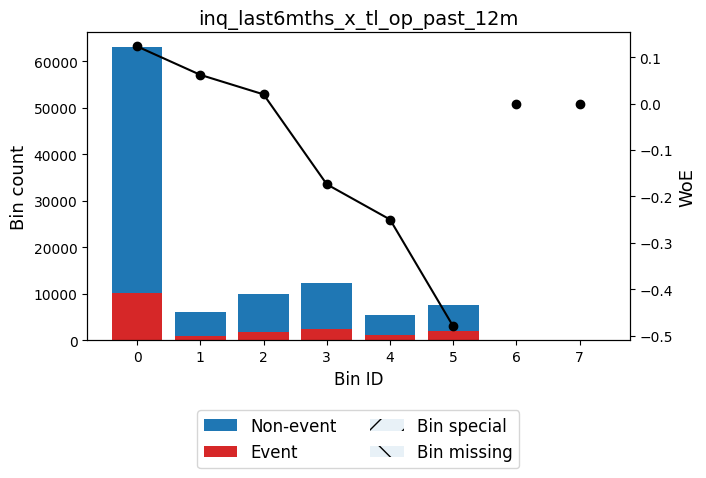


🔍 Feature: late_pymt_hist
✅ Total IV for late_pymt_hist: 0.0042
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.04) │   83059 │             0.1743 │ 0.03284708349601595  │ 0.000846012 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.04, 0.07) │    6665 │             0.1895 │ -0.06942608941036199 │ 0.000313359 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.07, 0.12) │    6873 │             0.2046 │ -0.16472427488804287 │ 0.00187415  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.12, inf)  │    8215 │             0.1976 │ -0.12112499733771531 │ 0.0011949   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤



🔍 Feature: dti_x_revol_util
✅ Total IV for dti_x_revol_util: 0.0788
╒════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 163.19)     │    8025 │             0.1148 │ 0.5202477470042672   │ 0.0174228   │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [163.19, 291.52)   │    7066 │             0.1268 │ 0.4068082025120714   │ 0.00974984  │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [291.52, 483.52)   │   11841 │             0.1386 │ 0.30437640676983957  │ 0.00946852  │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [483.52, 573.95)   │    5920 │             0.1524 │ 0.19346670545131217  │ 0.00198467  │
├────────────────────

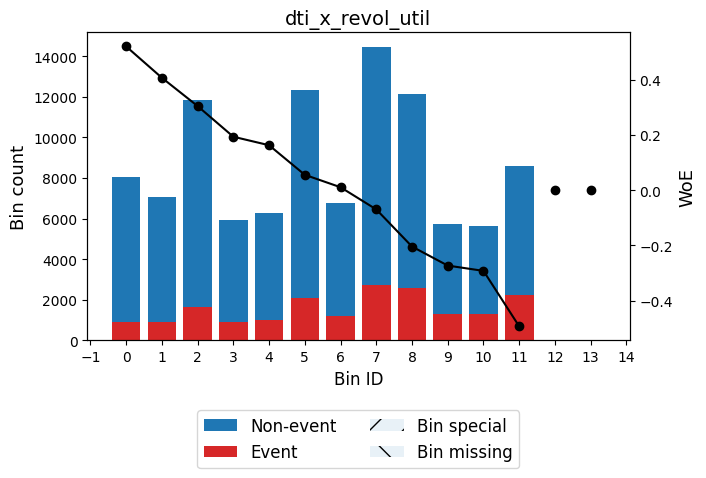


🔍 Feature: loan_amnt/annual_inc
✅ Total IV for loan_amnt/annual_inc: 0.1277
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.07) │    8027 │             0.1086 │ 0.5820717666691397    │ 0.021358    │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.07, 0.10) │    8068 │             0.122  │ 0.4512626004380389    │ 0.0134929   │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.10, 0.12) │    7873 │             0.1293 │ 0.38443289347351484   │ 0.00977508  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.12, 0.14) │    7976 │             0.136  │ 0.3259307239702163    │ 0.00726036  │
├──────────────┼─────────┼────────────────────┼────────────────


🔍 Feature: revol_util/annual_inc
✅ Total IV for revol_util/annual_inc: 0.0435
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.00) │    6804 │             0.123  │ 0.44146999562017486  │ 0.0109268   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.00) │    5312 │             0.1288 │ 0.389216669278585    │ 0.00674957  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.00) │    8753 │             0.1438 │ 0.26107944389685356  │ 0.00522491  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.00) │    9900 │             0.1553 │ 0.17127924843049813  │ 0.00262053  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─


🔍 Feature: bc_open_to_buy/annual_inc
✅ Total IV for bc_open_to_buy/annual_inc: 0.0309
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.00) │    7531 │             0.2283 │ -0.30452348210510727 │ 0.00732234  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.01) │    9168 │             0.2096 │ -0.1956222194876469  │ 0.00355947  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.01, 0.03) │   13662 │             0.1981 │ -0.12475053899716615 │ 0.00211032  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.03, 0.06) │   16214 │             0.1888 │ -0.06479729188906558 │ 0.000663078 │
├──────────────┼─────────┼────────────────────┼────────────────

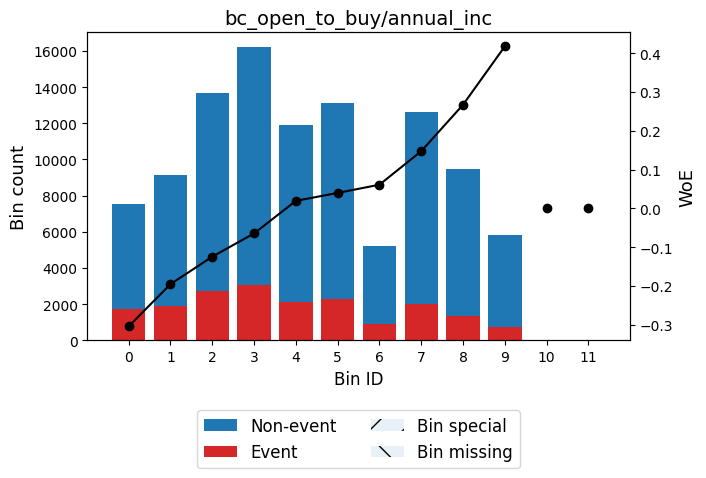


🔍 Feature: tl_op12m_x_inq6m
✅ Total IV for tl_op12m_x_inq6m: 0.0359
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   63096 │             0.1617 │ 0.12323449993595648  │ 0.00878378  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50) │    6042 │             0.1701 │ 0.061913331290696316 │ 0.000216599 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 2.50) │   10053 │             0.1762 │ 0.019834624910247234 │ 3.74941e-05 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 4.50) │   12389 │             0.2061 │ -0.1739255153178323  │ 0.00377693  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───────────

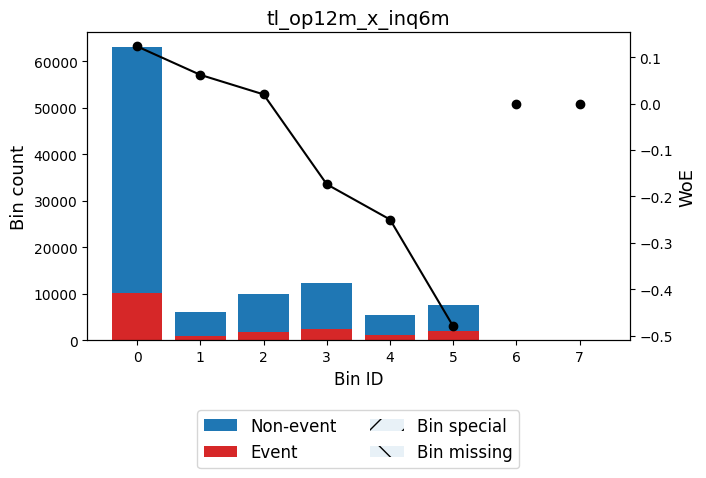


🔍 Feature: dti_x_inq
✅ Total IV for dti_x_inq: 0.0499
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 13.69)  │   69804 │             0.1586 │ 0.14618189145993066  │ 0.0135709   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [13.69, 17.62) │    5634 │             0.1778 │ 0.008285236195589407 │ 3.6801e-06  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [17.62, 21.87) │    5968 │             0.1882 │ -0.06076193182600842 │ 0.000214337 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [21.87, 29.05) │    8140 │             0.2109 │ -0.20339878505211484 │ 0.00342476  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼───

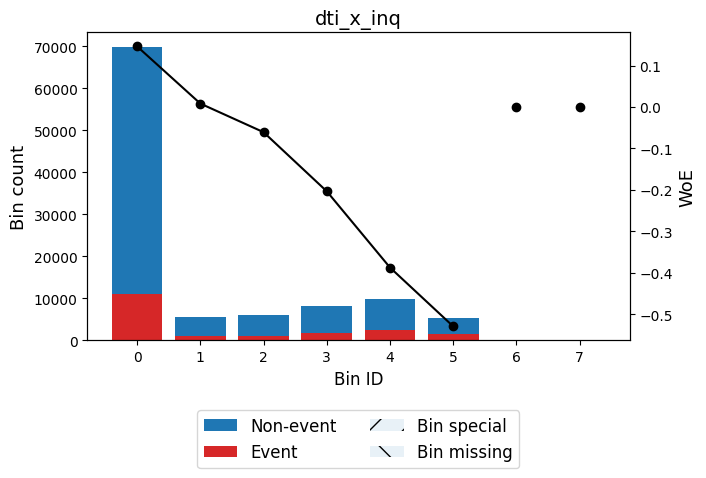


🔍 Feature: dti/fico_ratio
✅ Total IV for dti/fico_ratio: 0.1038
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.01) │    7749 │             0.112  │ 0.547622053129698     │ 0.0184668   │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.01, 0.01) │    6828 │             0.1258 │ 0.4158602647719627    │ 0.00981517  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.01, 0.02) │   14219 │             0.1329 │ 0.3532822272444487    │ 0.015067    │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.02, 0.02) │    7380 │             0.1466 │ 0.23871544084211127   │ 0.00371054  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼────

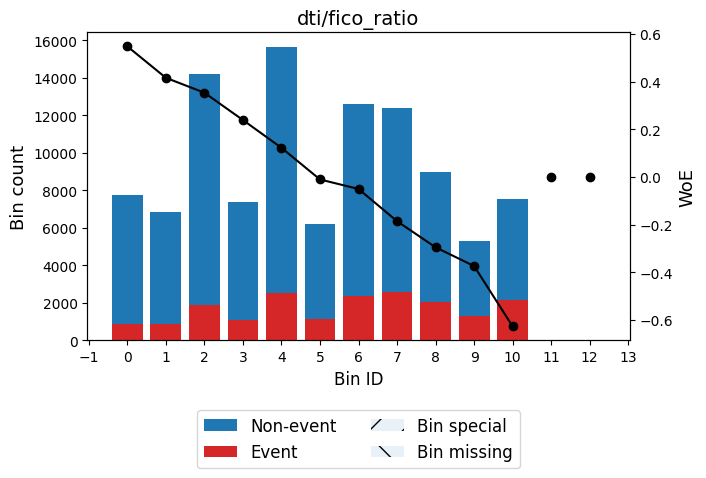


🔍 Feature: loan_amnt/tot_hi_cred_lim
✅ Total IV for loan_amnt/tot_hi_cred_lim: 0.0765
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.03) │    7427 │             0.107  │ 0.5986140807483671   │ 0.0207824   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.03, 0.04) │    6572 │             0.1149 │ 0.519116693249305    │ 0.0142118   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.04, 0.05) │    6659 │             0.1284 │ 0.39249564365488654  │ 0.00859471  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.05, 0.06) │    5582 │             0.148  │ 0.22786198287726256  │ 0.0025664   │
├──────────────┼─────────┼────────────────────┼────────────────

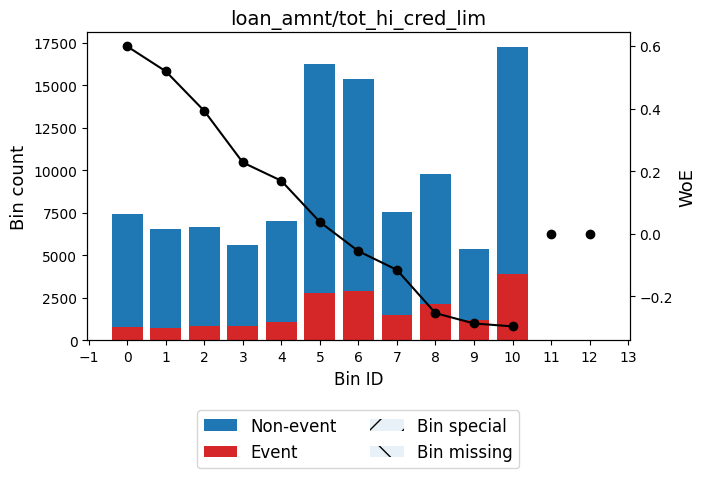


🔍 Feature: dti_x_term
✅ Total IV for dti_x_term: 0.2138
╒════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 239.22)     │    7636 │             0.1039 │ 0.6324527879052182   │ 0.0235755   │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [239.22, 333.48)   │    6649 │             0.1108 │ 0.5594460690262695   │ 0.0164701   │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [333.48, 432.90)   │    8990 │             0.1186 │ 0.4832773016802201   │ 0.0170566   │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [432.90, 503.10)   │    7394 │             0.1223 │ 0.4484829478935275   │ 0.0122254   │
├────────────────────┼─────────┼─

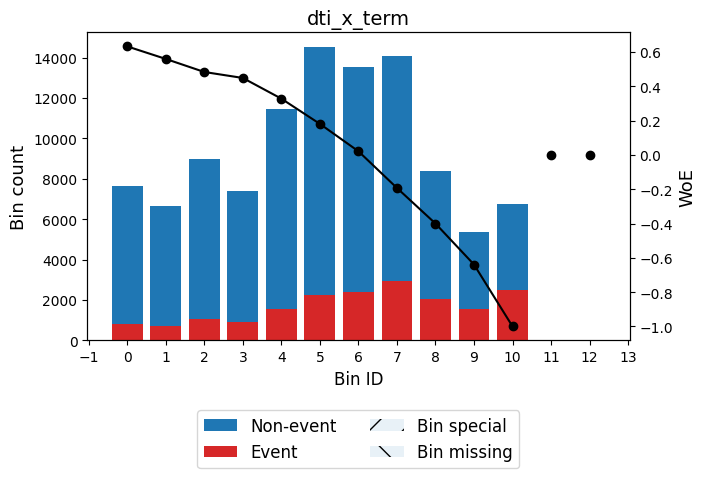

✅ Total IV for grade_numeric: 0.4381
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 1.50) │   18964 │             0.0554 │ 1.313079112925719    │ 0.19983    │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, 2.50) │   31291 │             0.1243 │ 0.42975844684487496  │ 0.0478109  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, 3.50) │   28850 │             0.1995 │ -0.13337544690788894 │ 0.00510757 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [3.50, 4.50) │   15220 │             0.2708 │ -0.5319463395992696  │ 0.0481857  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [4.50, inf)  │   10487 │             

In [12]:
# ========================================== Train - Test Split ==========================================
numerical_cols = get_numerical_cols(df1, TARGET_COL)

train_df1 , test_df1 = sample_split_order(initial_df=df1, sample_frac=0.1, cut_off_date=CUT_DATE, date_col='issue_d')

# == Observe IV of Numerical Variables == 
for feature in numerical_cols:
    if feature == "id":
        continue

    print(f"\n🔍 Feature: {feature}")

    if train_df1[feature].nunique() < 2:
        print("⚠️ Not enough variation. Skipping.")
        iv_categories["no_variation"].append(feature)
        continue

    x, y = train_df1[feature], train_df1[TARGET_COL]
    first_bin_and_classify_feature(feature=feature, x=x, y=y, monotonic_trend_type='auto')

    
train_df1 = tx_grade(train_df1)

first_bin_and_classify_feature('grade_numeric', train_df1['grade_numeric'], train_df1[TARGET_COL], dtype='numerical',monotonic_trend_type='auto' )


### 2.2 Categorical Features IV 

✅ Total IV for home_ownership: 0.0166
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ ['OTHER' 'MORTGAGE'] │   52303 │             0.1605 │ 0.13175474388313413   │ 0.00829964  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ ['OWN']              │   10863 │             0.1861 │ -0.047392629587044155 │ 0.000236338 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ ['RENT']             │   41646 │             0.2005 │ -0.13967955802093845  │ 0.0081023   │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Special              │       0 │             0      │ 0.0                   │ 0           │
├─────────────────────

✅ Total IV for verification_status: 0.0524
╒═════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                 │   Count │   Default Rate (%) │ WOE                  │         IV │
╞═════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ ['Not Verified']    │   31009 │             0.1307 │ 0.3723269160892164   │ 0.0362623  │
├─────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ ['Source Verified'] │   40200 │             0.1898 │ -0.07107816554571955 │ 0.00198208 │
├─────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ ['Verified']        │   33603 │             0.2109 │ -0.20339810412611836 │ 0.0141378  │
├─────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special             │       0 │             0      │ 0.0                  │ 0          │
├─────────────────────┼─────────┼──────────────

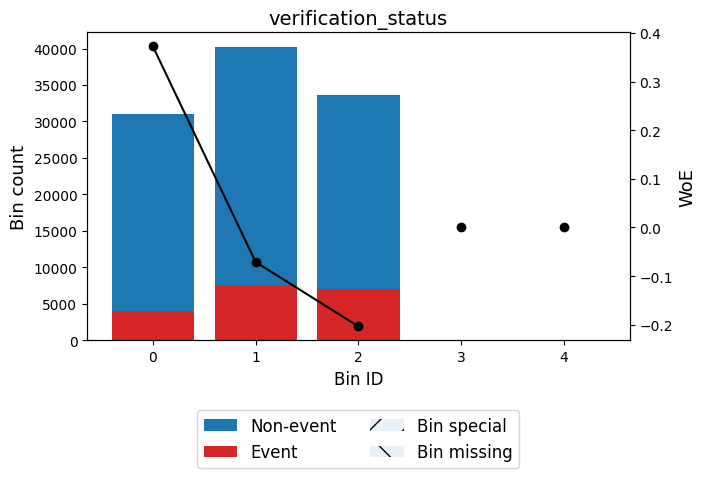

✅ Total IV for initial_list_status: 0.0006
╒═════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin     │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ ['f']   │   48204 │             0.175  │ 0.027705126034381466  │ 0.000349881 │
├─────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ ['w']   │   56608 │             0.1825 │ -0.023209507872985924 │ 0.000293107 │
├─────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Special │       0 │             0      │ 0.0                   │ 0           │
├─────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Missing │       0 │             0      │ 0.0                   │ 0           │
├─────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│         │  104812 │             0.1791 │                       │

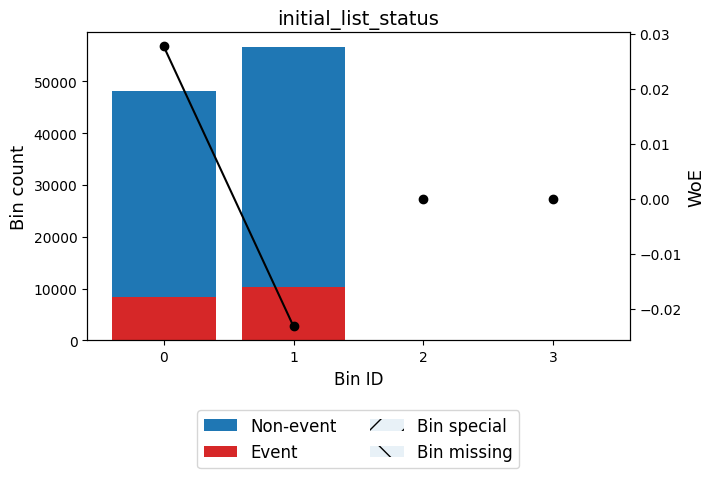

✅ Total IV for application_type: 0.0000
╒════════════════════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin                        │   Count │   Default Rate (%) │ WOE   │   IV │
╞════════════════════════════╪═════════╪════════════════════╪═══════╪══════╡
│ ['Individual' 'Joint App'] │  104812 │             0.1791 │ 0.0   │    0 │
├────────────────────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special                    │       0 │             0      │ 0.0   │    0 │
├────────────────────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing                    │       0 │             0      │ 0.0   │    0 │
├────────────────────────────┼─────────┼────────────────────┼───────┼──────┤
│                            │  104812 │             0.1791 │       │    0 │
╘════════════════════════════╧═════════╧════════════════════╧═══════╧══════╛


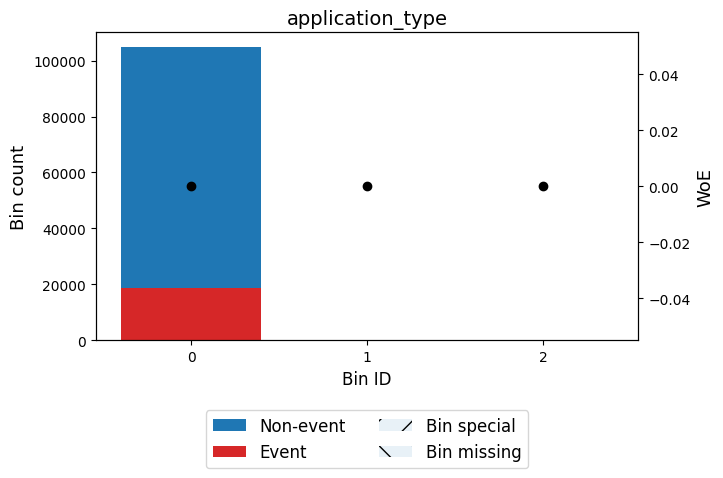

In [13]:
# == Observe IV of Categorical Variables == 
categorical_features = get_categorical_cols(df1, TARGET_COL)

for feat in categorical_features: 
    if feat != 'grade': 
        first_bin_and_classify_feature(feat, train_df1[feat], train_df1[TARGET_COL], dtype='categorical', monotonic_trend_type='auto')


### 2.3 Feature Importance Rankings

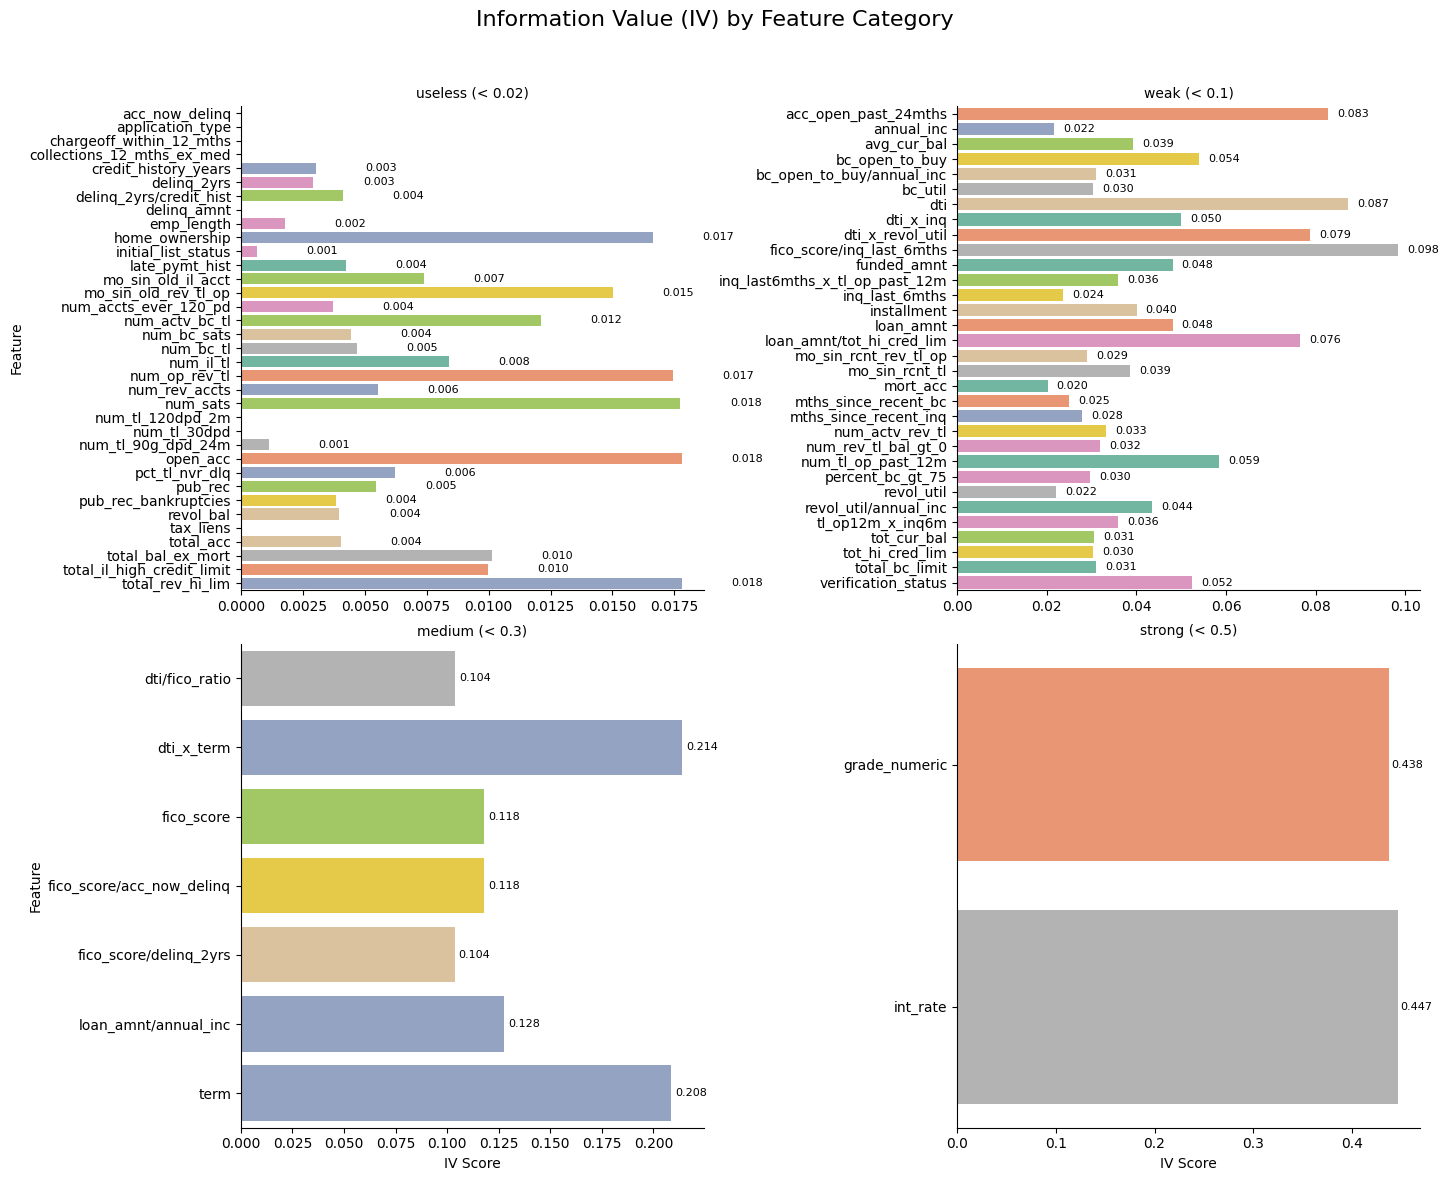

In [14]:
# === 1. Flatten into a clean DataFrame ===
rows = []
for category, items in iv_categories.items():
    for feature, iv in items:
        rows.append({"Feature": feature, "IV": float(iv), "Category": category})

df_iv1 = pd.DataFrame(rows).sort_values(by='Feature')

# === 2. Create faceted plots, showing only relevant features in each ===
g = sns.catplot(
    data=df_iv1,
    kind="bar",
    x="IV",
    y="Feature",
    col="Category",
    col_wrap=2,
    height=6,
    aspect=1.2,
    sharex=False,       # <== allow different x scales
    sharey=False,       # <== allow different features per facet
    palette="Set2"
)

# === 3. Annotate bars ===
for ax in g.axes.flat:
    for bar in ax.patches:
        width = bar.get_width()
        if width > 0:
            y = bar.get_y() + bar.get_height() / 2
            ax.text(width + 0.002, y, f"{width:.3f}", va='center', fontsize=8)

# === 4. Final polish ===
g.set_titles(col_template="{col_name}")
g.set_xlabels("IV Score")
g.set_ylabels("Feature")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Information Value (IV) by Feature Category", fontsize=16)
plt.show()


In [15]:
print(iv_categories)

{'useless (< 0.02)': [('emp_length', np.float64(0.0017729361378595785)), ('delinq_2yrs', np.float64(0.0029301155033107564)), ('open_acc', np.float64(0.01779708346264201)), ('pub_rec', np.float64(0.005460469040728642)), ('revol_bal', np.float64(0.003969343965081974)), ('total_acc', np.float64(0.0040342069343094755)), ('collections_12_mths_ex_med', np.float64(0.0)), ('acc_now_delinq', np.float64(0.0)), ('total_rev_hi_lim', np.float64(0.01779582875922525)), ('chargeoff_within_12_mths', np.float64(0.0)), ('delinq_amnt', np.float64(0.0)), ('mo_sin_old_il_acct', np.float64(0.007385492295961255)), ('mo_sin_old_rev_tl_op', np.float64(0.015021721666335225)), ('num_accts_ever_120_pd', np.float64(0.0037091798873168597)), ('num_actv_bc_tl', np.float64(0.012106159825433935)), ('num_bc_sats', np.float64(0.004440760508742)), ('num_bc_tl', np.float64(0.004674883442003772)), ('num_il_tl', np.float64(0.008397003599458918)), ('num_op_rev_tl', np.float64(0.01744646507019778)), ('num_rev_accts', np.float64

In [16]:
# == Drop all useless columns (IV < 0.02) automatically) -> Noise == 
# === Drop all useless columns (IV < 0.02) ===
useless_cols = [
    feature
    for category, feature_list in iv_categories.items()
    if category == 'useless (< 0.02)'
    for feature, _ in feature_list
]


print(useless_cols)

df1 = df1.drop(*useless_cols)


['emp_length', 'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'total_rev_hi_lim', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort', 'total_il_high_credit_limit', 'credit_history_years', 'delinq_2yrs/credit_hist', 'late_pymt_hist', 'home_ownership', 'initial_list_status', 'application_type']


✅ Total IV for tot_hi_cred_lim: 0.0273
╒════════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 110627.50)      │   48653 │             0.2002 │ -0.13748986134230967 │ 0.00916483  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [110627.50, 162563.50) │   16683 │             0.1754 │ 0.025205981468494176 │ 0.000100311 │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [162563.50, 242691.00) │   13661 │             0.1752 │ 0.026713539675458087 │ 9.22149e-05 │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [242691.00, 317011.50) │    9746 │             0.1572 │ 0.15656044280353543  │ 0.00216593  │
├──────────

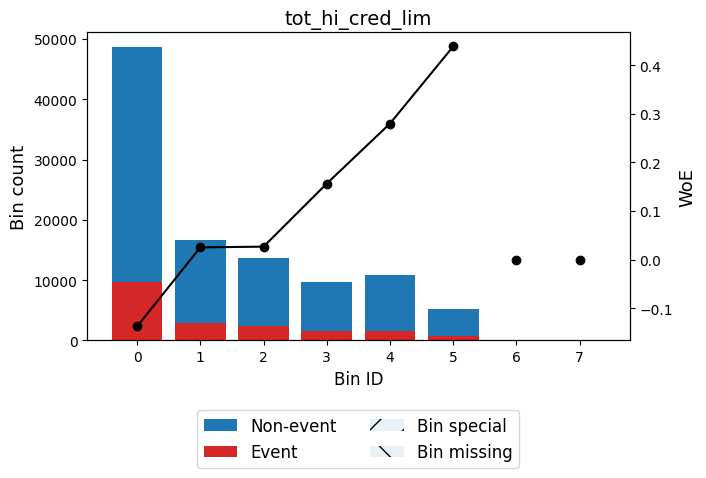

In [17]:
# == Dealing with non-monotonic columns with IV >=0.02 == 


# == tot_hi_cred_lim (v-shaped) == 
first_bin_and_classify_feature('tot_hi_cred_lim', train_df1['tot_hi_cred_lim'], train_df1[TARGET_COL], dtype='numerical', monotonic_trend_type='auto_asc_desc')

# IV dropped from 0.0361 to 0.0344
